In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load Elbert data
df = pd.read_excel('../raw_data/Elbert.xlsx')

print(f'Original data shape: {df.shape}')

# View unique Employee Types
print("\nUnique Employee Types:")
print(df['Employee Type'].unique())
print(f"\nTotal unique Employee Types: {df['Employee Type'].nunique()}")
print("\nEmployee Type value counts:")
print(df['Employee Type'].value_counts())

# Filter out records where Filled = 'Unfilled' AND Needs Substitute = 'NO'
df = df[~((df['Filled'] == 'Unfilled') & (df['Needs Substitute'] == 'NO'))]
print(f'\nAfter Unfilled/NO filter: {df.shape}')

# Include only Employee Type = '10 Month Teacher', '11 Month Teacher', '12 Month Teacher'
df = df[df['Employee Type'].isin(['10 Month Teacher', '11 Month Teacher', '12 Month Teacher'])]
print(f'After Employee Type filter: {df.shape}')

df.head()


Original data shape: (48247, 20)

Unique Employee Types:
['10 Month Teacher' 'Admin' '10 Month Para' '11 Month Teacher' 'PreK Para'
 'Supp Cust' 'Bus Monitor' '12 Month Teacher' 'ECSD Para AS GACE 0-7'
 'ECSD PreK Para 0-7' 'ECSD Para BA GACE 0-7' 'Registered Nurse']

Total unique Employee Types: 12

Employee Type value counts:
Employee Type
Bus Monitor              19223
10 Month Teacher         16135
Admin                     4607
10 Month Para             3524
Supp Cust                 2450
PreK Para                  947
11 Month Teacher           514
12 Month Teacher           455
Registered Nurse           261
ECSD Para AS GACE 0-7      113
ECSD Para BA GACE 0-7       12
ECSD PreK Para 0-7           6
Name: count, dtype: int64

After Unfilled/NO filter: (35191, 20)
After Employee Type filter: (11286, 20)


,Work ID,Conf#,Date,Reason,Employee Last,Employee First,Employee Identifier,Employee Title,Employee Type,School Name,Start Time,End Time,Duration,Absence Type,Percent of Day,Filled,Needs Substitute,Sub ID,Substitute Last,Substitute First
0,8449776,431695263,2020-12-18,Sick,Adair,Curtis,100258,Grades 9-12 Social Studies,10 Month Teacher,Elbert County Comprehensive High School,07:30:00,15:30:00,8.0,Full Day,1.0,Filled,YES,5507688.0,Cervantes,Alma
1,8449776,434147041,2021-01-13,Sick,Adair,Curtis,100258,Grades 9-12 Social Studies,10 Month Teacher,Elbert County Comprehensive High School,07:30:00,15:30:00,8.0,Full Day,1.0,Filled,YES,5585393.0,Odom,Bilinda
2,8449776,434814151,2021-01-19,Sick,Adair,Curtis,100258,Grades 9-12 Social Studies,10 Month Teacher,Elbert County Comprehensive High School,07:30:00,15:30:00,8.0,Full Day,1.0,Filled,YES,5046405.0,Dye,Kathy
3,8449776,434814151,2021-01-20,Sick,Adair,Curtis,100258,Grades 9-12 Social Studies,10 Month Teacher,Elbert County Comprehensive High School,07:30:00,15:30:00,8.0,Full Day,1.0,Filled,YES,5046405.0,Dye,Kathy
4,8449776,434814151,2021-01-21,Sick,Adair,Curtis,100258,Grades 9-12 Social Studies,10 Month Teacher,Elbert County Comprehensive High School,07:30:00,15:30:00,8.0,Full Day,1.0,Filled,YES,5046405.0,Dye,Kathy


In [ ]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create School Year column based on July 1 - June 30 calendar
# If month is July-December, school year is YYYY-YYYY+1
# If month is January-June, school year is YYYY-1-YYYY
def get_school_year(date):
    if pd.isna(date):
        return None
    year = date.year
    month = date.month
    if month >= 7:  # July to December
        return f'{year}-{year+1}'
    else:  # January to June
        return f'{year-1}-{year}'

df['School Year'] = df['Date'].apply(get_school_year)

print("School Year column created")
print(f"\nSchool Year distribution:")
print(df['School Year'].value_counts().sort_index())

# Calculate absence days
# Full Day = 1 day, Half Day = 0.5 day, Custom Duration = use Duration column (convert to days)

def calculate_absence_days(row):
    if row['Absence Type'] == 'Full Day':
        return 1.0
    elif row['Absence Type'] in ['AM Half Day', 'PM Half Day']:
        return 0.5
    elif row['Absence Type'] == 'Custom Duration':
        # Duration is in hours, convert to days (assuming 7-8 hours per day, use 7.5 as average)
        hours = pd.to_numeric(row['Duration'], errors='coerce')
        if pd.isna(hours):
            return 0
        return hours / 7.5
    else:
        return 0

df['Absence_Days'] = df.apply(calculate_absence_days, axis=1)

print("\nAbsence days calculated")
print(f"Total absence days: {df['Absence_Days'].sum():.2f}")
print(f"\nAbsence Type distribution:")
print(df.groupby('Absence Type')['Absence_Days'].agg(['sum', 'count']))


School Year column created

School Year distribution:
School Year
2020-2021    2019
2021-2022    2245
2022-2023    2738
2023-2024    2210
2024-2025    2074
Name: count, dtype: int64

Absence days calculated
Total absence days: 10509.60

Absence Type distribution:
                         sum  count
Absence Type                       
AM Half Day       212.500000    425
Custom Duration  1337.104438   1405
Full Day         8464.000000   8464
PM Half Day       496.000000    992


Total Number of Teachers by School Year:
  School Year  Total Teachers
0   2020-2021             174
1   2021-2022             195
2   2022-2023             199
3   2023-2024             213
4   2024-2025             198


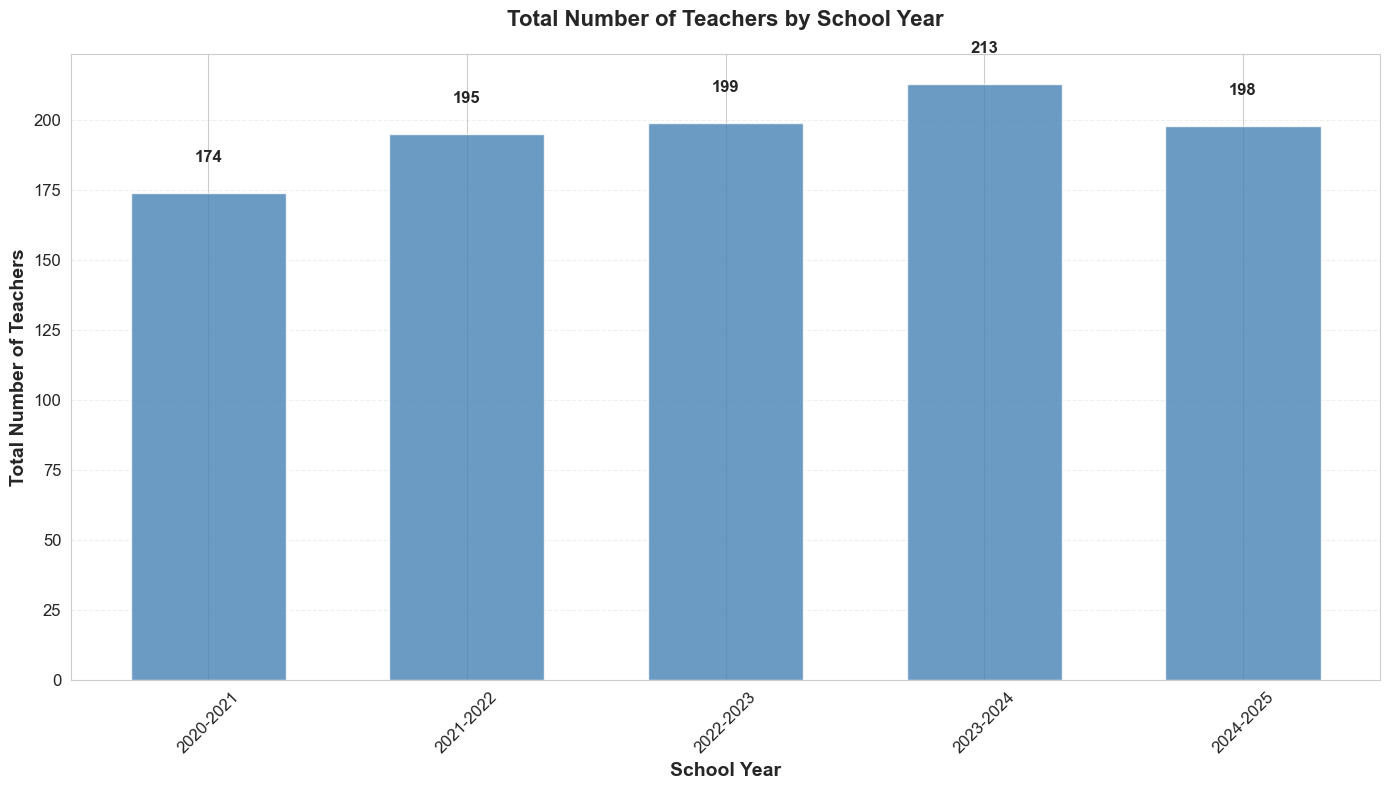

In [ ]:
# Total Number of Teachers by School Year
teachers_by_year = df.groupby('School Year')['Employee Identifier'].nunique().reset_index()
teachers_by_year.columns = ['School Year', 'Total Teachers']
teachers_by_year = teachers_by_year.sort_values('School Year')

print("Total Number of Teachers by School Year:")
print(teachers_by_year)

# Visualization
plt.figure(figsize=(14, 8))
plt.bar(teachers_by_year['School Year'], teachers_by_year['Total Teachers'], color='steelblue', width=0.6, alpha=0.8)
plt.title('Total Number of Teachers by School Year', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(teachers_by_year['Total Teachers']):
    plt.text(i, v + 10, str(int(v)), ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


Total Number of Teacher Absences by School Year:
  School Year  Total Absences
0   2020-2021            2019
1   2021-2022            2245
2   2022-2023            2738
3   2023-2024            2210
4   2024-2025            2074


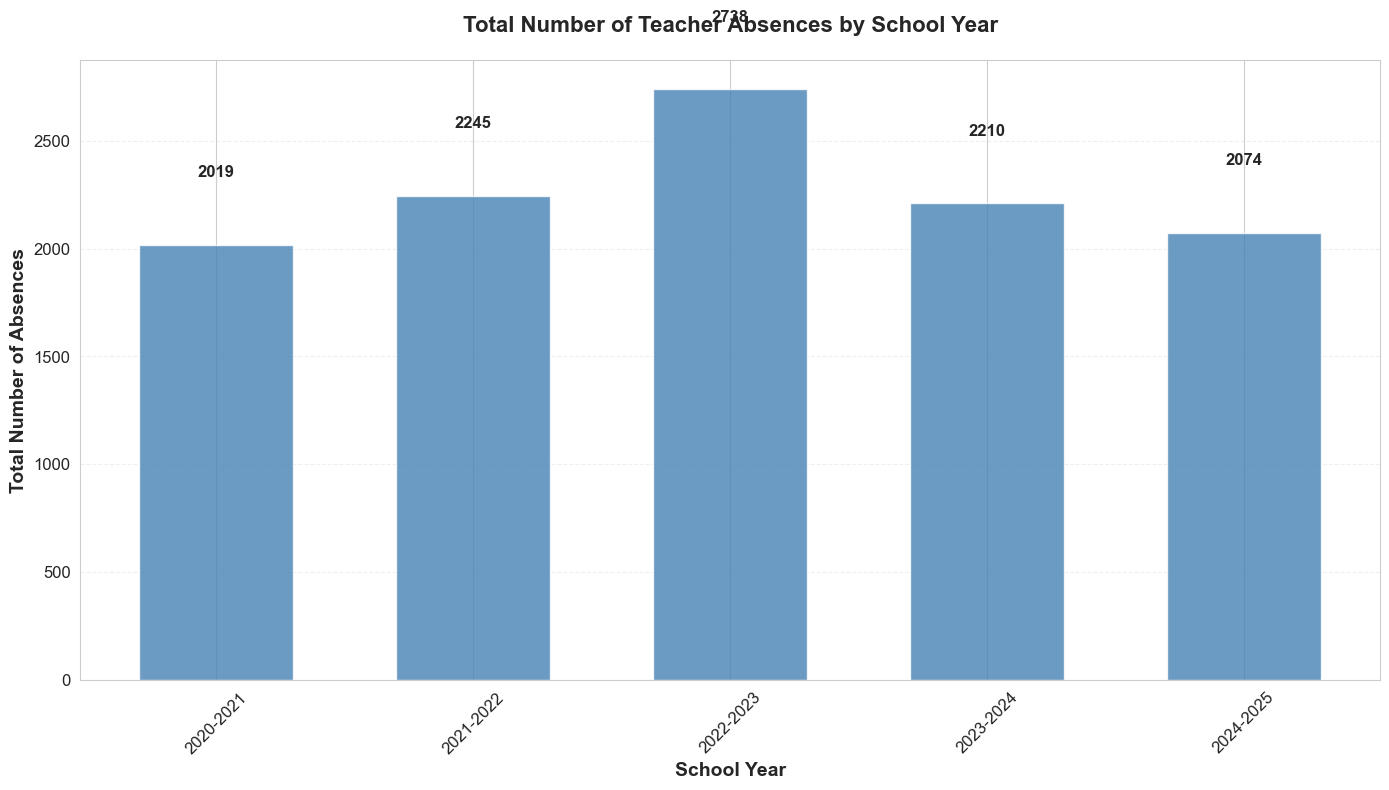

In [ ]:
# Total Number of Teacher Absences by School Year - Bar Chart
absences_by_year = df.groupby('School Year').size().reset_index()
absences_by_year.columns = ['School Year', 'Total Absences']
absences_by_year = absences_by_year.sort_values('School Year')

print("Total Number of Teacher Absences by School Year:")
print(absences_by_year)

# Bar chart - separate, larger visualization
plt.figure(figsize=(14, 8))
plt.bar(absences_by_year['School Year'], absences_by_year['Total Absences'], 
        color='steelblue', width=0.6, alpha=0.8)
plt.title('Total Number of Teacher Absences by School Year', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Number of Absences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(absences_by_year['Total Absences']):
    plt.text(i, v + 300, str(int(v)), ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


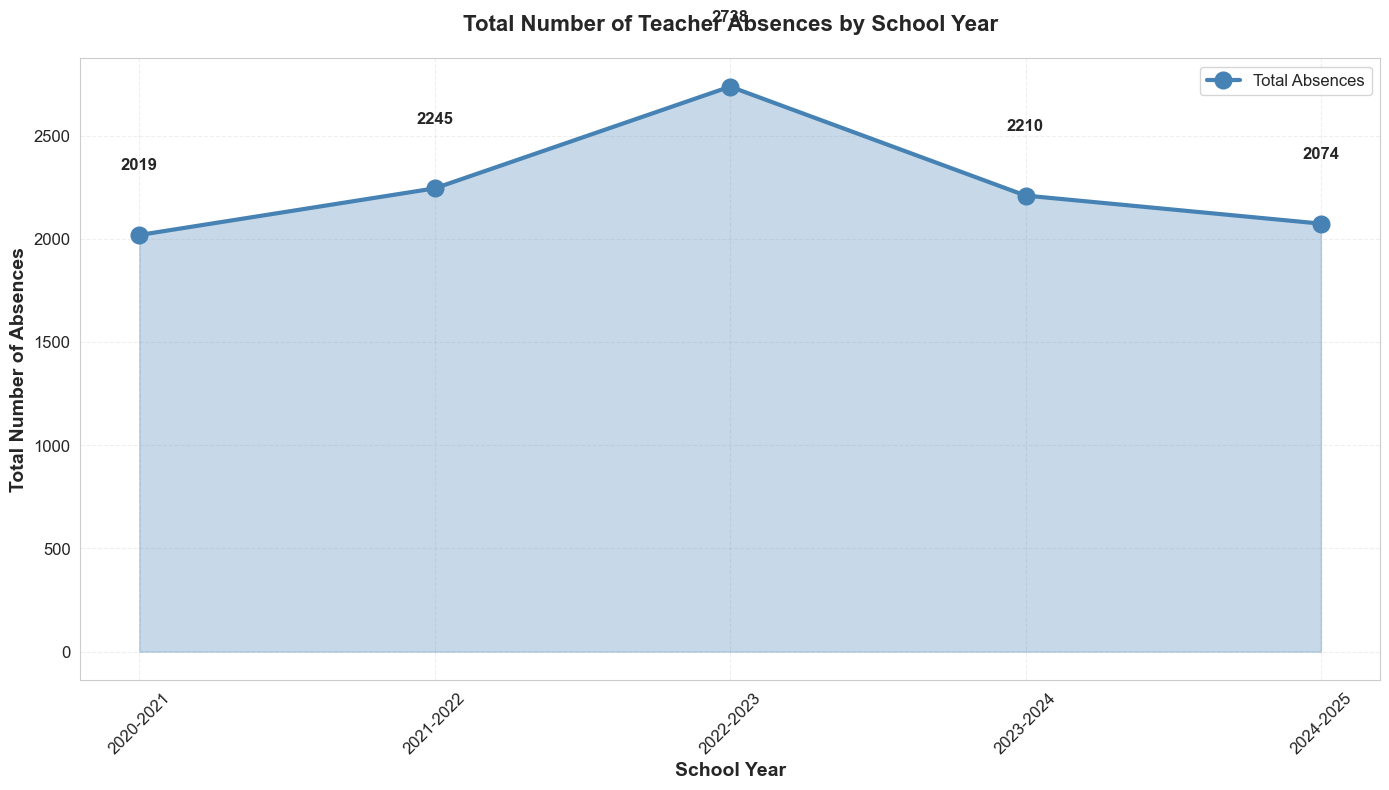

In [ ]:
# Total Number of Teacher Absences by School Year - Line Chart
if 'absences_by_year' not in locals():
    absences_by_year = df.groupby('School Year').size().reset_index()
    absences_by_year.columns = ['School Year', 'Total Absences']
    absences_by_year = absences_by_year.sort_values('School Year')

# Line chart with area - separate, larger visualization
plt.figure(figsize=(14, 8))
plt.plot(absences_by_year['School Year'], absences_by_year['Total Absences'], 
        marker='o', linewidth=3, markersize=12, color='steelblue', label='Total Absences')
plt.fill_between(absences_by_year['School Year'], absences_by_year['Total Absences'], 
                 alpha=0.3, color='steelblue')
plt.title('Total Number of Teacher Absences by School Year', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Number of Absences', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
for i, v in enumerate(absences_by_year['Total Absences']):
    plt.text(i, v + 300, str(int(v)), ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate total absence days per teacher per school year
teacher_absence_days = df.groupby(['School Year', 'Employee Identifier'])['Absence_Days'].sum().reset_index()
teacher_absence_days.columns = ['School Year', 'Employee Identifier', 'Total_Days']

print(f"Total teachers with absences: {teacher_absence_days['Employee Identifier'].nunique()}")
print(f"\nSample data:")
print(teacher_absence_days.head(10))
print(f"\nSummary statistics:")
print(teacher_absence_days.groupby('School Year')['Total_Days'].describe())


Total teachers with absences: 302

Sample data:
  School Year  Employee Identifier  Total_Days
0   2020-2021                  800    1.000000
1   2020-2021                 2110    3.933333
2   2020-2021                 2280   17.500000
3   2020-2021                 2360    3.000000
4   2020-2021                 2610   12.133333
5   2020-2021                 4921    8.300000
6   2020-2021                 5980    5.566667
7   2020-2021                 6150    4.000000
8   2020-2021                 6880    2.000000
9   2020-2021                 6890    7.000000

Summary statistics:
             count       mean        std  min       25%       50%        75%  \
School Year                                                                    
2020-2021    174.0   9.623436   9.798950  0.5  3.533333  7.133333  12.566667   
2021-2022    195.0  10.490028   8.526594  0.5  5.000000  9.000000  12.633333   
2022-2023    199.0  12.792518  12.338828  0.5  6.250000  9.633333  13.783333   
2023-2024    2

In [ ]:
# Employee Absence Days by School Year - Summary Table
employee_absence_table = teacher_absence_days.pivot_table(
    index='Employee Identifier',
    columns='School Year',
    values='Total_Days',
    fill_value=0.0
).reset_index()

employee_absence_table.columns.name = None
employee_absence_table['Total'] = employee_absence_table.select_dtypes(include=[np.number]).sum(axis=1)
employee_absence_table = employee_absence_table.sort_values('Total', ascending=False).reset_index(drop=True)

# Format the table nicely
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: f'{x:.1f}')

print("=" * 120)
print("Employee Absence Days by School Year (Top Employees by Total Absence Days)")
print("=" * 120)
print(f"\nTotal number of employees: {len(employee_absence_table)}")
print(f"\nTop 20 employees by total absence days:\n")

# Display top 20 with nice formatting
display_table = employee_absence_table.head(20).copy()
display_table = display_table.round(1)

# Use display for better table rendering in notebook
from IPython.display import display
display(display_table.style.format({
    'Employee Identifier': '{:.0f}',
    '2020-2021': '{:.1f}',
    '2021-2022': '{:.1f}',
    '2022-2023': '{:.1f}',
    '2023-2024': '{:.1f}',
    '2024-2025': '{:.1f}',
    'Total': '{:.1f}'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), 
                                 ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#D9E1F2')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', 'white')]}
]).set_properties(**{'font-size': '11pt', 'padding': '8px'}))


Employee Absence Days by School Year (Top Employees by Total Absence Days)

Total number of employees: 302

Top 20 employees by total absence days:



,Employee Identifier,2020-2021,2021-2022,2022-2023,2023-2024,2024-2025,Total
0,9880117,0.0,5.0,0.0,0.0,0.0,9880122.0
1,100812,0.0,0.0,0.0,0.0,24.6,100836.6
2,100820,0.0,0.0,0.0,0.0,9.6,100829.6
3,100814,0.0,0.0,0.0,0.0,10.1,100824.1
4,100809,0.0,0.0,0.0,0.0,15.1,100824.1
5,100788,0.0,0.0,0.0,0.0,32.1,100820.1
6,100816,0.0,0.0,0.0,0.0,4.1,100820.1
7,100810,0.0,0.0,0.0,0.0,8.5,100818.5
8,100813,0.0,0.0,0.0,0.0,3.0,100816.0
9,100805,0.0,0.0,0.0,0.0,5.0,100810.0


In [ ]:
# Analysis for different absence day thresholds
# Elbert substitute cost: $150.00 per day
SUBSTITUTE_COST_PER_DAY = 150.00

thresholds = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
results = {}

for threshold in thresholds:
    teachers_above_threshold = teacher_absence_days[teacher_absence_days['Total_Days'] > threshold].copy()
    total_teachers = teacher_absence_days.groupby('School Year')['Employee Identifier'].nunique()
    teachers_above = teachers_above_threshold.groupby('School Year')['Employee Identifier'].nunique()
    total_days_above = teachers_above_threshold.groupby('School Year')['Total_Days'].sum()
    pct_teachers = (teachers_above / total_teachers * 100).fillna(0)
    
    results[threshold] = {
        'total_teachers': total_teachers,
        'teachers_above': teachers_above,
        'total_days_above': total_days_above,
        'pct_teachers': pct_teachers
    }
    
    print(f"\n=== Threshold: >{threshold} Days ===")
    print(f"Total teachers with >{threshold} days: {len(teachers_above_threshold)}")
    print(f"\nBy School Year:")
    summary = pd.DataFrame({
        'Total Teachers': total_teachers,
        f'Teachers (>{threshold} days)': teachers_above,
        f'Total Days (>{threshold} days)': total_days_above,
        f'% of Teachers': pct_teachers
    }).fillna(0)
    print(summary)




=== Threshold: >10 Days ===
Total teachers with >10 days: 382

By School Year:
             Total Teachers  Teachers (>10 days)  Total Days (>10 days)  \
School Year                                                               
2020-2021               174                   62                 1141.1   
2021-2022               195                   82                 1419.5   
2022-2023               199                   93                 1909.3   
2023-2024               213                   71                 1310.1   
2024-2025               198                   74                 1203.5   

             % of Teachers  
School Year                 
2020-2021             35.6  
2021-2022             42.1  
2022-2023             46.7  
2023-2024             33.3  
2024-2025             37.4  

=== Threshold: >15 Days ===
Total teachers with >15 days: 158

By School Year:
             Total Teachers  Teachers (>15 days)  Total Days (>15 days)  \
School Year                         

In [ ]:
# Summary tables with deductible days, reimbursable days, and replacement costs
summary_tables = {}

for threshold in thresholds:
    data = results[threshold]
    years = sorted(teacher_absence_days['School Year'].unique())
    
    summary_data = []
    for year in years:
        num_staff = int(data['teachers_above'].get(year, 0))
        total_days = data['total_days_above'].get(year, 0)
        deductible_days = threshold * num_staff  # Insurance coverage starts from day (threshold+1): >10 from day 11, >15 from day 16, >20 from day 21, >30 from day 31, >40 from day 41
        reimbursable_days = total_days - deductible_days
        replacement_cost = reimbursable_days * SUBSTITUTE_COST_PER_DAY
        total_teachers = int(data['total_teachers'].get(year, 0))
        pct_teachers = data['pct_teachers'].get(year, 0)
        
        summary_data.append({
            'School Year': year,
            '# of Staff (>{} days)'.format(threshold): num_staff,
            'Total Days Taken': round(total_days, 1),
            'Deductible Days': -deductible_days,
            'Reimbursable Days': round(reimbursable_days, 1),
            'Replacement Cost': round(replacement_cost, 1),
            '% of Teachers': round(pct_teachers, 1)
        })
    
    # Calculate 5-year average
    avg_num_staff = np.mean([d['# of Staff (>{} days)'.format(threshold)] for d in summary_data])
    avg_total_days = np.mean([d['Total Days Taken'] for d in summary_data])
    avg_deductible = np.mean([abs(d['Deductible Days']) for d in summary_data])
    avg_reimbursable = np.mean([d['Reimbursable Days'] for d in summary_data])
    avg_cost = np.mean([d['Replacement Cost'] for d in summary_data])
    avg_pct = np.mean([d['% of Teachers'] for d in summary_data])
    
    summary_data.append({
        'School Year': '5-Year Avg',
        '# of Staff (>{} days)'.format(threshold): round(avg_num_staff, 1),
        'Total Days Taken': round(avg_total_days, 1),
        'Deductible Days': -round(avg_deductible, 1),
        'Reimbursable Days': round(avg_reimbursable, 1),
        'Replacement Cost': round(avg_cost, 1),
        '% of Teachers': round(avg_pct, 1)
    })
    
    summary_df = pd.DataFrame(summary_data)
    summary_tables[threshold] = summary_df
    
    print(f"\n{'='*80}")
    print(f"GREATER THAN {threshold} DAYS ABSENCE SUMMARY (Replacement Cost @ ${SUBSTITUTE_COST_PER_DAY}/day)")
    print(f"{'='*80}")
    print(summary_df.to_string(index=False))
    print()



GREATER THAN 10 DAYS ABSENCE SUMMARY (Replacement Cost @ $150.0/day)
School Year  # of Staff (>10 days)  Total Days Taken  Deductible Days  Reimbursable Days  Replacement Cost  % of Teachers
  2020-2021                   62.0            1141.1           -620.0              521.1           78160.0           35.6
  2021-2022                   82.0            1419.5           -820.0              599.5           89928.3           42.1
  2022-2023                   93.0            1909.3           -930.0              979.3          146900.0           46.7
  2023-2024                   71.0            1310.1           -710.0              600.1           90015.0           33.3
  2024-2025                   74.0            1203.5           -740.0              463.5           69528.0           37.4
 5-Year Avg                   76.4            1396.7           -764.0              632.7           94906.3           39.0


GREATER THAN 15 DAYS ABSENCE SUMMARY (Replacement Cost @ $150.0/day)
Schoo

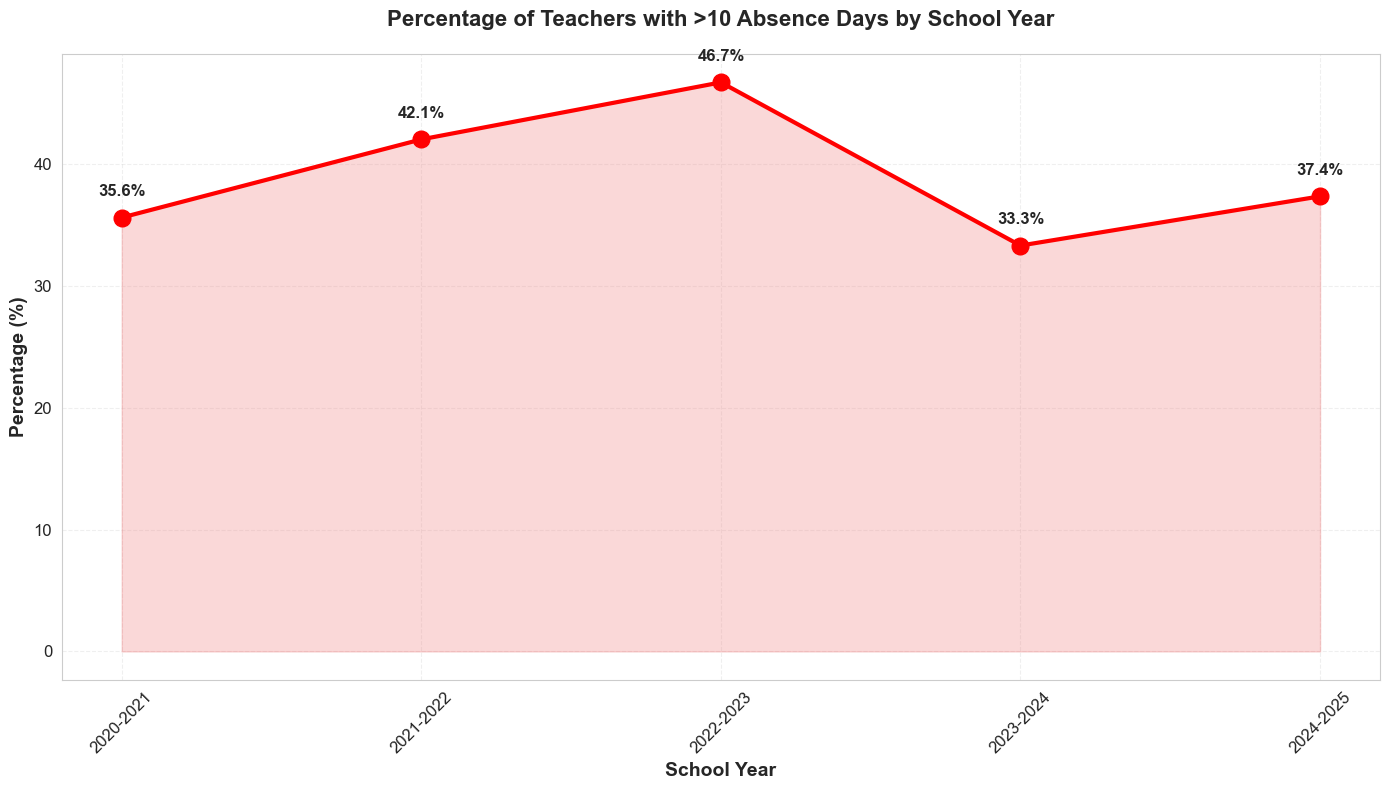

In [ ]:
# Percentage of Teachers with >10 Absence Days by School Year
threshold = 10
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='o', linewidth=3, markersize=12, color='red')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightcoral')
plt.title(f'Percentage of Teachers with >10 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
for i, v in enumerate(pct_teachers):
    plt.text(i, v + 1.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


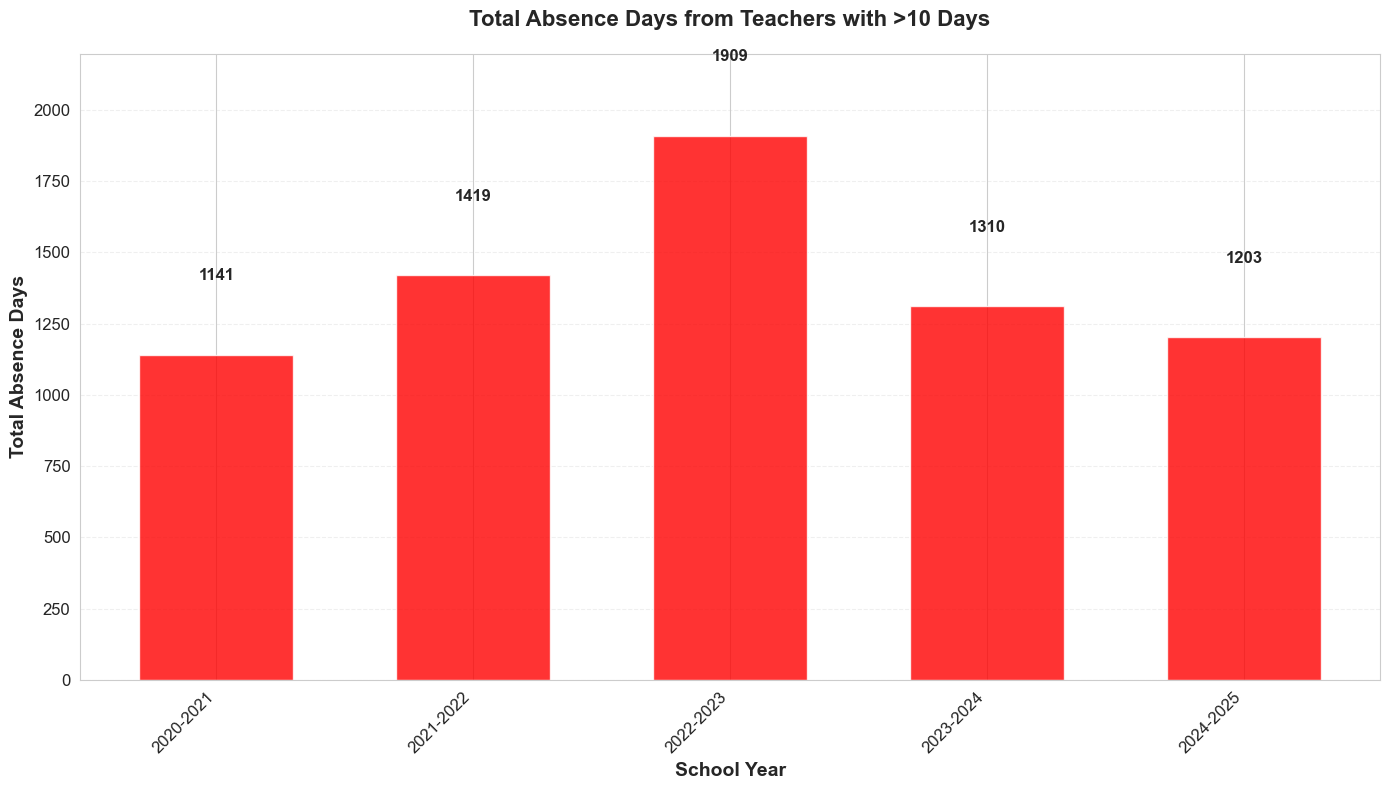

In [ ]:
# Total Absence Days from Teachers with >10 Days
threshold = 10
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='red', width=0.6, alpha=0.8)

# Set y-axis limit to give more room for labels
max_value = max(total_days) if total_days else 0
plt.ylim(0, max_value * 1.15)  # Add 15% more space at top

plt.title(f'Total Absence Days from Teachers with >10 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Position labels with better offset (proportional to max value)
offset = max(max_value * 0.08, 250)  # Use 8% of max or at least 250
for i, v in enumerate(total_days):
    plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# ABCover Profitability Analysis
# Goal: Find the right combination of waiting period and payment rate to ESS
# that results in profitable coverage while only charging schools 10% more
# ============================================================================

# Constants
ABCOVER_RATE_TO_SCHOOL = 150.00  # Rate ABCover charges to Elbert school per day
FILL_RATE = 0.90  # ESS typically fills 90% of absences
PREMIUM_INCREASE = 0.10  # ABCover charges school 10% more than ESS rate

# Calculate ESS rate (back-calculate: if ABCover charges 10% more, then ESS rate = ABCover rate / 1.10)
CURRENT_ESS_RATE = ABCOVER_RATE_TO_SCHOOL / (1 + PREMIUM_INCREASE)  # ESS's current rate
PREMIUM_PER_DAY = ABCOVER_RATE_TO_SCHOOL - CURRENT_ESS_RATE  # ABCover's revenue per filled absence

print("="*80)
print("ABCOVER PRICING STRUCTURE - ELBERT")
print("="*80)
print(f"Current ESS Rate (to school): ${CURRENT_ESS_RATE:.2f}/day")
print(f"ABCover Rate to School (10% increase): ${ABCOVER_RATE_TO_SCHOOL:.2f}/day")
print(f"Premium per filled absence: ${PREMIUM_PER_DAY:.2f}/day")
print(f"Total premium on all filled absences = ABCover's Annual Revenue")
print()

# Calculate total absences and filled absences (5-year average)
total_absences_by_year = df.groupby('School Year').size()
avg_absences_per_year = total_absences_by_year.mean()
filled_absences_per_year = avg_absences_per_year * FILL_RATE

print("="*80)
print("ANNUAL ABSENCE STATISTICS (5-Year Average)")
print("="*80)
print(f"Total Absences per Year: {avg_absences_per_year:,.0f}")
print(f"Filled Absences per Year (90% fill rate): {filled_absences_per_year:,.0f}")
print()

# Calculate ABCover's annual revenue (10% premium on ALL filled absences)
# Revenue = Premium per day × ALL Filled Absences (FIXED - does not change with threshold or payment rate)
annual_revenue = filled_absences_per_year * PREMIUM_PER_DAY
print(f"ABCover Annual Revenue (Premium on ALL filled absences): ${annual_revenue:,.2f}")
print(f"  (Premium: ${PREMIUM_PER_DAY:.2f}/day × {filled_absences_per_year:,.0f} filled absences)")
print(f"  This revenue is FIXED - school pays premium on all absences regardless of threshold")
print()

# Calculate ABCover's base rate to ESS (10% less than what ABCover charges school)
ABCOVER_RATE_TO_ESS_BASE = ABCOVER_RATE_TO_SCHOOL * (1 - 0.10)  # 10% less
print(f"ABCover Rate to ESS (10% less than school rate): ${ABCOVER_RATE_TO_ESS_BASE:.2f}/day")
print(f"  (ABCover charges school: ${ABCOVER_RATE_TO_SCHOOL:.2f}/day)")
print(f"  (ABCover pays ESS: ${ABCOVER_RATE_TO_ESS_BASE:.2f}/day)")
print()

# Test all thresholds from 10 to 80 (multiples of 5) - MUST include 25, 35, 45, 50, 55, 60, 65, 70, 75
thresholds_to_test = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

# School-specific rate to highlight (rate ABCover charges school)
SCHOOL_RATE = ABCOVER_RATE_TO_SCHOOL  # $150.00 for Elbert
# Calculate the payment rate that would result in this school rate
# If rate_charged_to_school = payment_rate * 1.10, then payment_rate = school_rate / 1.10
PAYMENT_RATE_FOR_SCHOOL_RATE = SCHOOL_RATE / 1.10

# Test different payment rates to ESS (what ABCover pays ESS for reimbursable days)
# MUST include payment rate that results in school rate ($150.00 charged to school = $136.36 paid to ESS)
# This ensures Rate Charged to School = $150.00 appears in every waiting period
# Also include various other rates
payment_rates_to_test = [80, 90, 100, 110, 120, 130, ABCOVER_RATE_TO_ESS_BASE, 140, 150, PAYMENT_RATE_FOR_SCHOOL_RATE]
# Ensure PAYMENT_RATE_FOR_SCHOOL_RATE is included (don't round it out)
payment_rates_to_test = sorted(list(set([round(rate, 2) for rate in payment_rates_to_test])))  # Remove duplicates and sort
# Verify school rate payment is included
if PAYMENT_RATE_FOR_SCHOOL_RATE not in payment_rates_to_test:
    payment_rates_to_test.append(round(PAYMENT_RATE_FOR_SCHOOL_RATE, 2))
    payment_rates_to_test = sorted(list(set(payment_rates_to_test)))

# Get reimbursable days from summary tables (5-year average)
results_matrix = []

for threshold in thresholds_to_test:
    if threshold in summary_tables:
        # Get 5-year average reimbursable days
        avg_row = summary_tables[threshold][summary_tables[threshold]['School Year'] == '5-Year Avg']
        if len(avg_row) > 0:
            reimbursable_days = avg_row['Reimbursable Days'].values[0]
            
            # Apply 90% fill rate to reimbursable days
            filled_reimbursable_days = reimbursable_days * FILL_RATE
            
            for payment_rate in payment_rates_to_test:
                # Revenue is FIXED (premium on ALL filled absences, not just reimbursable days)
                # School pays ABCover premium on all absences regardless of threshold
                # annual_revenue is already calculated above (fixed for all scenarios)
                
                # Rate Charged to School = Rate Paid to ESS × 1.10 (10% more - DYNAMIC)
                rate_charged_to_school = payment_rate * 1.10
                
                # Calculate ABCover's cost (what they pay to ESS for reimbursable days only)
                # Cost = Rate Paid to ESS × Filled Reimbursable Days (only days above threshold)
                abcover_cost = filled_reimbursable_days * payment_rate
                
                # Calculate profit/loss
                # Revenue (fixed) - Cost (varies by threshold and payment rate)
                profit_loss = annual_revenue - abcover_cost
                
                # Calculate profit margin
                profit_margin_pct = (profit_loss / annual_revenue * 100) if annual_revenue > 0 else 0
                
                # Check if Rate Charged to School matches the school-specific rate (to highlight later)
                is_school_rate = (abs(rate_charged_to_school - SCHOOL_RATE) < 0.01)
                
                results_matrix.append({
                    'Waiting Period': f'>{threshold} days',
                    'Reimbursable Days': round(reimbursable_days, 1),
                    'Filled Reimbursable Days': round(filled_reimbursable_days, 1),
                    'Rate Charged to School': f'${rate_charged_to_school:.2f}',
                    'Rate Paid to ESS': f'${payment_rate:.2f}',
                    'Total Cost to ABCover': f'${abcover_cost:,.2f}',
                    'ABCover Annual Revenue': f'${annual_revenue:,.2f}',
                    'Net Profit/Loss': f'${profit_loss:,.2f}',
                    'Profit Margin %': f'{profit_margin_pct:.1f}%',
                    'Is_School_Rate': is_school_rate  # Flag for highlighting
                })

# Create results DataFrame
results_df = pd.DataFrame(results_matrix)

# Display results with color coding
print("\n" + "="*140)
print("PROFITABILITY MATRIX - All Scenarios")
print("="*140)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Convert Net Profit/Loss to numeric for styling
results_df['Profit_Loss_Numeric'] = results_df['Net Profit/Loss'].str.replace('$', '').str.replace(',', '').astype(float)

# Create styled DataFrame with color coding
def color_profit_loss(val):
    """Color profit green, loss red"""
    try:
        if isinstance(val, str):
            # Remove $ and commas, handle negative sign
            numeric_val = float(val.replace('$', '').replace(',', '').strip())
        else:
            numeric_val = float(val)
        if numeric_val > 0:
            return 'background-color: #90EE90'  # Light green
        elif numeric_val < 0:
            return 'background-color: #FFB6C1'  # Light red
        else:
            return 'background-color: #FFFFFF'  # White
    except:
        return 'background-color: #FFFFFF'  # Default white if parsing fails

def highlight_school_rate(row):
    """Highlight rows where Rate Paid to ESS equals school rate"""
    if row.get('Is_School_Rate', False):
        return ['background-color: #FFD700'] * len(row)  # Gold highlight for school rate
    return [''] * len(row)

# Apply styling to Net Profit/Loss column (exclude helper columns from display)
display_df = results_df.drop(columns=['Profit_Loss_Numeric', 'Is_School_Rate'], errors='ignore')
styled_df = display_df.style.applymap(color_profit_loss, subset=['Net Profit/Loss']).apply(highlight_school_rate, axis=1)
from IPython.display import display
display(styled_df)
print()

# Highlight profitable scenarios
profitable_scenarios = results_df[results_df['Profit_Loss_Numeric'] > 0].copy()
print("\n" + "="*140)
print("PROFITABLE SCENARIOS (Profit > $0)")
print("="*140)
if len(profitable_scenarios) > 0:
    # Apply green color to profitable scenarios (exclude helper column from display)
    display_profitable = profitable_scenarios.drop(columns=['Profit_Loss_Numeric'], errors='ignore')
    styled_profitable = display_profitable.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])
    display(styled_profitable)
    print(f"\nTotal Profitable Scenarios: {len(profitable_scenarios)}")
else:
    print("No profitable scenarios found with current parameters.")
print()

# Find optimal scenarios (highest profit)
print("="*140)
print("TOP 15 MOST PROFITABLE SCENARIOS")
print("="*140)

# Get top 15 by profit, but also include school rate scenarios even if not in top 15
top_scenarios = results_df.nlargest(15, 'Profit_Loss_Numeric').copy()

# Also include school rate scenarios if not already in top 15
school_rate_scenarios = results_df[results_df['Is_School_Rate'] == True]
for idx, row in school_rate_scenarios.iterrows():
    if idx not in top_scenarios.index:
        top_scenarios = pd.concat([top_scenarios, pd.DataFrame([row])], ignore_index=True)

# Sort by profit again and take top 15
top_scenarios = top_scenarios.nlargest(15, 'Profit_Loss_Numeric')[['Waiting Period', 'Rate Charged to School', 'Rate Paid to ESS', 
                                                                 'Filled Reimbursable Days',
                                                                 'Total Cost to ABCover', 'ABCover Annual Revenue', 
                                                                 'Net Profit/Loss', 'Profit Margin %', 'Is_School_Rate']].copy()

# Apply styling
def style_top_scenarios(row):
    styles = [''] * len(row)
    profit_loss_idx = list(row.index).index('Net Profit/Loss')
    
    # Color profit/loss
    try:
        profit_val = float(str(row['Net Profit/Loss']).replace('$', '').replace(',', '').strip())
        if profit_val > 0:
            styles[profit_loss_idx] = 'background-color: #90EE90'  # Green
        elif profit_val < 0:
            styles[profit_loss_idx] = 'background-color: #FFB6C1'  # Red
    except:
        pass
    
    # Highlight school rate rows
    if row.get('Is_School_Rate', False):
        styles = ['background-color: #FFD700'] * len(row)  # Gold for entire row
        # But keep profit/loss color
        try:
            profit_val = float(str(row['Net Profit/Loss']).replace('$', '').replace(',', '').strip())
            if profit_val > 0:
                styles[profit_loss_idx] = 'background-color: #90EE90'  # Green
            elif profit_val < 0:
                styles[profit_loss_idx] = 'background-color: #FFB6C1'  # Red
        except:
            pass
    
    return styles

styled_top = top_scenarios.drop(columns=['Is_School_Rate'], errors='ignore').style.apply(style_top_scenarios, axis=1)
display(styled_top)
print()

# Summary by waiting period (best payment rate for each)
print("="*140)
print("BEST PAYMENT RATE FOR EACH WAITING PERIOD (Most Profitable)")
print("="*140)
best_by_threshold = []
for threshold in thresholds_to_test:
    threshold_data = results_df[results_df['Waiting Period'] == f'>{threshold} days']
    if len(threshold_data) > 0:
        best_scenario = threshold_data.nlargest(1, 'Profit_Loss_Numeric')
        if len(best_scenario) > 0 and best_scenario['Profit_Loss_Numeric'].values[0] > 0:
            best_by_threshold.append(best_scenario[['Waiting Period', 'Rate Charged to School', 'Rate Paid to ESS', 
                                                     'Filled Reimbursable Days',
                                                     'Total Cost to ABCover', 'Net Profit/Loss', 'Profit Margin %']].iloc[0])

if len(best_by_threshold) > 0:
    best_df = pd.DataFrame(best_by_threshold)
    # Apply green color to all (they're all profitable)
    styled_best = best_df.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])
    display(styled_best)
else:
    print("No profitable scenarios found.")
print()

ABCOVER PRICING STRUCTURE - ELBERT
Current ESS Rate (to school): $136.36/day
ABCover Rate to School (10% increase): $150.00/day
Premium per filled absence: $13.64/day
Total premium on all filled absences = ABCover's Annual Revenue

ANNUAL ABSENCE STATISTICS (5-Year Average)
Total Absences per Year: 2,257
Filled Absences per Year (90% fill rate): 2,031

ABCover Annual Revenue (Premium on ALL filled absences): $27,702.00
  (Premium: $13.64/day × 2,031 filled absences)
  This revenue is FIXED - school pays premium on all absences regardless of threshold

ABCover Rate to ESS (10% less than school rate): $135.00/day
  (ABCover charges school: $150.00/day)
  (ABCover pays ESS: $135.00/day)


PROFITABILITY MATRIX - All Scenarios


/var/folders/gq/wkkqjm_d00ggs329s5bxsx300000gn/T/ipykernel_9599/2168811661.py:161: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = display_df.style.applymap(color_profit_loss, subset=['Net Profit/Loss']).apply(highlight_school_rate, axis=1)


,Waiting Period,Reimbursable Days,Filled Reimbursable Days,Rate Charged to School,Rate Paid to ESS,Total Cost to ABCover,ABCover Annual Revenue,Net Profit/Loss,Profit Margin %
0,>10 days,632.700000,569.400000,$88.00,$80.00,"$45,554.40","$27,702.00","$-17,852.40",-64.4%
1,>10 days,632.700000,569.400000,$99.00,$90.00,"$51,248.70","$27,702.00","$-23,546.70",-85.0%
2,>10 days,632.700000,569.400000,$110.00,$100.00,"$56,943.00","$27,702.00","$-29,241.00",-105.6%
3,>10 days,632.700000,569.400000,$121.00,$110.00,"$62,637.30","$27,702.00","$-34,935.30",-126.1%
4,>10 days,632.700000,569.400000,$132.00,$120.00,"$68,331.60","$27,702.00","$-40,629.60",-146.7%
5,>10 days,632.700000,569.400000,$143.00,$130.00,"$74,025.90","$27,702.00","$-46,323.90",-167.2%
6,>10 days,632.700000,569.400000,$148.50,$135.00,"$76,873.05","$27,702.00","$-49,171.05",-177.5%
7,>10 days,632.700000,569.400000,$150.00,$136.36,"$77,647.47","$27,702.00","$-49,945.47",-180.3%
8,>10 days,632.700000,569.400000,$154.00,$140.00,"$79,720.20","$27,702.00","$-52,018.20",-187.8%
9,>10 days,632.700000,569.400000,$165.00,$150.00,"$85,414.50","$27,702.00","$-57,712.50",-208.3%




PROFITABLE SCENARIOS (Profit > $0)


/var/folders/gq/wkkqjm_d00ggs329s5bxsx300000gn/T/ipykernel_9599/2168811661.py:174: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_profitable = display_profitable.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])


,Waiting Period,Reimbursable Days,Filled Reimbursable Days,Rate Charged to School,Rate Paid to ESS,Total Cost to ABCover,ABCover Annual Revenue,Net Profit/Loss,Profit Margin %,Is_School_Rate
10,>15 days,371.600000,334.400000,$88.00,$80.00,"$26,755.20","$27,702.00",$946.80,3.4%,False
20,>20 days,253.700000,228.300000,$88.00,$80.00,"$18,266.40","$27,702.00","$9,435.60",34.1%,False
21,>20 days,253.700000,228.300000,$99.00,$90.00,"$20,549.70","$27,702.00","$7,152.30",25.8%,False
22,>20 days,253.700000,228.300000,$110.00,$100.00,"$22,833.00","$27,702.00","$4,869.00",17.6%,False
23,>20 days,253.700000,228.300000,$121.00,$110.00,"$25,116.30","$27,702.00","$2,585.70",9.3%,False
24,>20 days,253.700000,228.300000,$132.00,$120.00,"$27,399.60","$27,702.00",$302.40,1.1%,False
30,>25 days,185.700000,167.100000,$88.00,$80.00,"$13,370.40","$27,702.00","$14,331.60",51.7%,False
31,>25 days,185.700000,167.100000,$99.00,$90.00,"$15,041.70","$27,702.00","$12,660.30",45.7%,False
32,>25 days,185.700000,167.100000,$110.00,$100.00,"$16,713.00","$27,702.00","$10,989.00",39.7%,False
33,>25 days,185.700000,167.100000,$121.00,$110.00,"$18,384.30","$27,702.00","$9,317.70",33.6%,False



Total Profitable Scenarios: 126

TOP 15 MOST PROFITABLE SCENARIOS


,Waiting Period,Rate Charged to School,Rate Paid to ESS,Filled Reimbursable Days,Total Cost to ABCover,ABCover Annual Revenue,Net Profit/Loss,Profit Margin %
0,>80 days,$88.00,$80.00,0.800000,$64.80,"$27,702.00","$27,637.20",99.8%
1,>80 days,$99.00,$90.00,0.800000,$72.90,"$27,702.00","$27,629.10",99.7%
2,>80 days,$110.00,$100.00,0.800000,$81.00,"$27,702.00","$27,621.00",99.7%
3,>80 days,$121.00,$110.00,0.800000,$89.10,"$27,702.00","$27,612.90",99.7%
4,>80 days,$132.00,$120.00,0.800000,$97.20,"$27,702.00","$27,604.80",99.6%
5,>80 days,$143.00,$130.00,0.800000,$105.30,"$27,702.00","$27,596.70",99.6%
6,>80 days,$148.50,$135.00,0.800000,$109.35,"$27,702.00","$27,592.65",99.6%
7,>80 days,$150.00,$136.36,0.800000,$110.45,"$27,702.00","$27,591.55",99.6%
29,>80 days,$150.00,$136.36,0.800000,$110.45,"$27,702.00","$27,591.55",99.6%
8,>80 days,$154.00,$140.00,0.800000,$113.40,"$27,702.00","$27,588.60",99.6%



BEST PAYMENT RATE FOR EACH WAITING PERIOD (Most Profitable)


/var/folders/gq/wkkqjm_d00ggs329s5bxsx300000gn/T/ipykernel_9599/2168811661.py:252: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_best = best_df.style.applymap(lambda x: 'background-color: #90EE90', subset=['Net Profit/Loss'])


,Waiting Period,Rate Charged to School,Rate Paid to ESS,Filled Reimbursable Days,Total Cost to ABCover,Net Profit/Loss,Profit Margin %
10,>15 days,$88.00,$80.00,334.400000,"$26,755.20",$946.80,3.4%
20,>20 days,$88.00,$80.00,228.300000,"$18,266.40","$9,435.60",34.1%
30,>25 days,$88.00,$80.00,167.100000,"$13,370.40","$14,331.60",51.7%
40,>30 days,$88.00,$80.00,127.100000,"$10,166.40","$17,535.60",63.3%
50,>35 days,$88.00,$80.00,93.200000,"$7,459.20","$20,242.80",73.1%
60,>40 days,$88.00,$80.00,64.300000,"$5,140.80","$22,561.20",81.4%
70,>45 days,$88.00,$80.00,40.100000,"$3,204.00","$24,498.00",88.4%
80,>50 days,$88.00,$80.00,25.100000,"$2,008.80","$25,693.20",92.7%
90,>55 days,$88.00,$80.00,14.200000,"$1,137.60","$26,564.40",95.9%
100,>60 days,$88.00,$80.00,7.600000,$612.00,"$27,090.00",97.8%


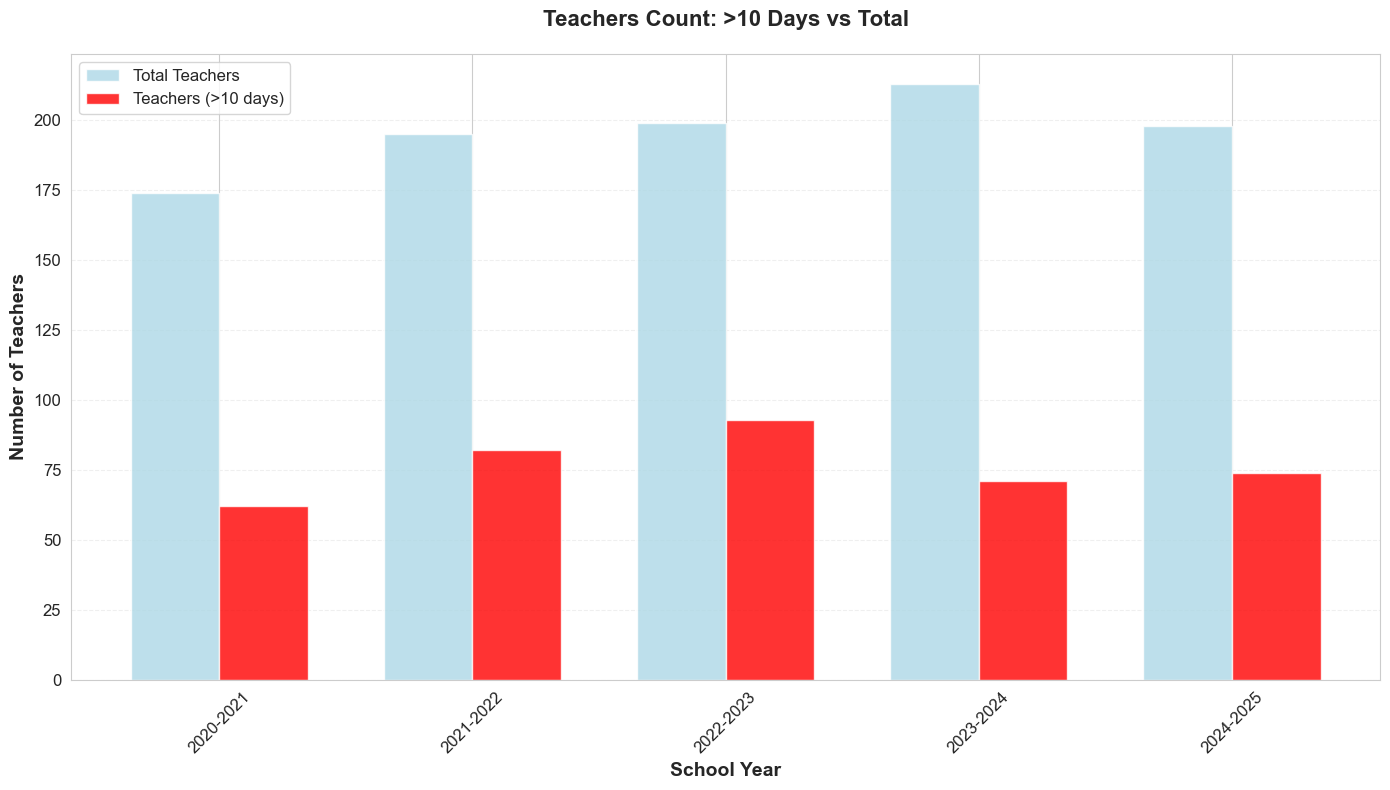

In [ ]:
# Teachers Count: >10 Days vs Total
threshold = 10
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>10 days)', color='red', alpha=0.8)
plt.title(f'Teachers Count: >10 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


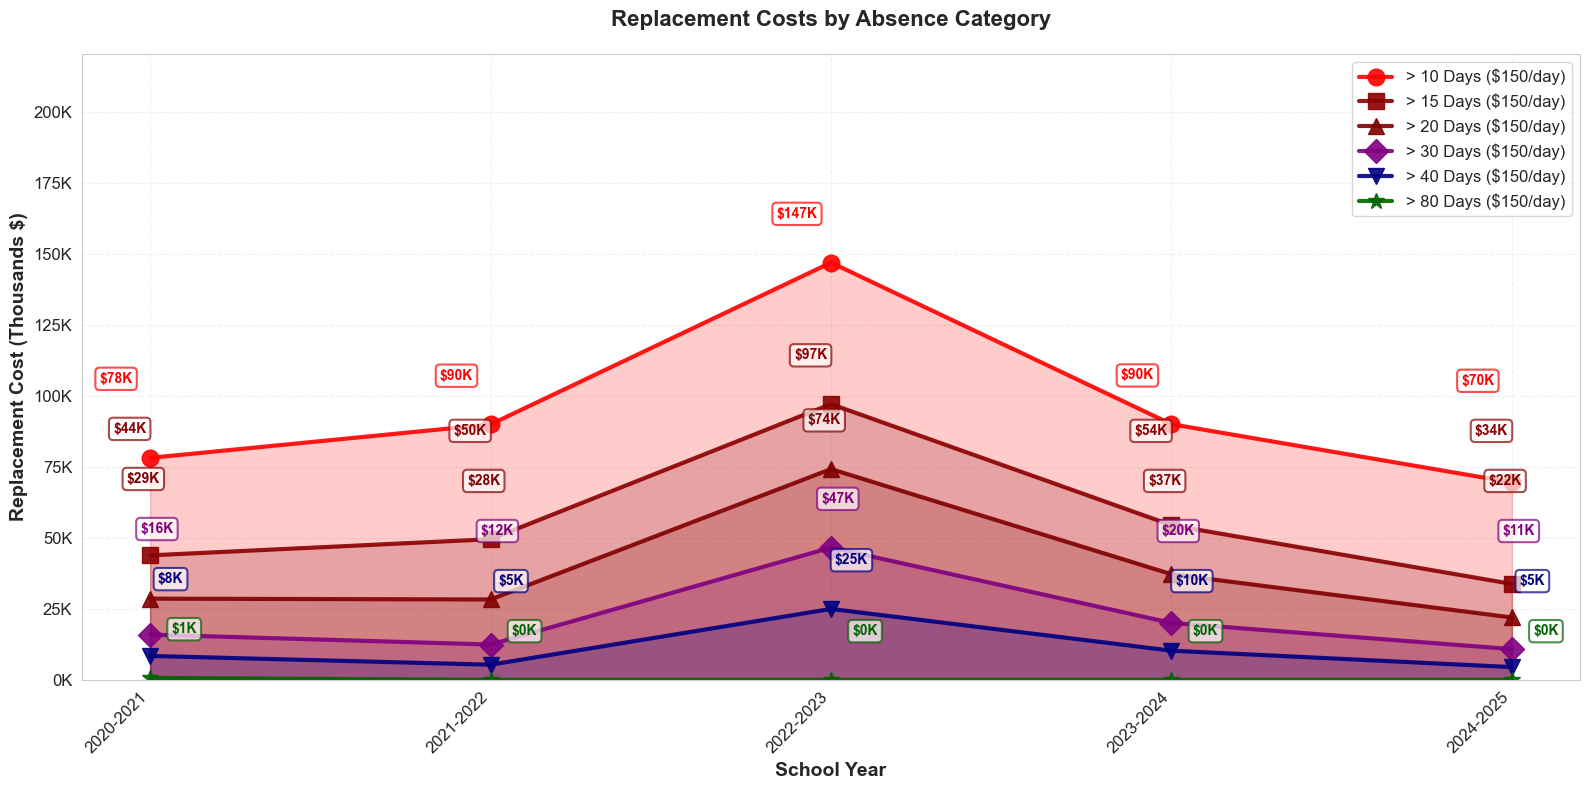

In [ ]:
# Replacement Costs by Absence Category
years = sorted(teacher_absence_days['School Year'].unique())

replacement_costs = {}
for threshold in thresholds:
    costs = []
    for year in years:
        summary = summary_tables[threshold]
        year_data = summary[summary['School Year'] == year]
        if len(year_data) > 0:
            costs.append(year_data['Replacement Cost'].values[0])
        else:
            costs.append(0)
    replacement_costs[threshold] = costs

plt.figure(figsize=(16, 8))
plt.plot(years, replacement_costs[10], marker='o', linewidth=3, markersize=12, 
         label='> 10 Days ($150/day)', color='red', alpha=0.9)
plt.fill_between(years, replacement_costs[10], alpha=0.2, color='red')
plt.plot(years, replacement_costs[15], marker='s', linewidth=3, markersize=12, 
         label='> 15 Days ($150/day)', color='darkred', alpha=0.9)
plt.fill_between(years, replacement_costs[15], alpha=0.2, color='darkred')
plt.plot(years, replacement_costs[20], marker='^', linewidth=3, markersize=12, 
         label='> 20 Days ($150/day)', color='maroon', alpha=0.9)
plt.fill_between(years, replacement_costs[20], alpha=0.2, color='maroon')
plt.plot(years, replacement_costs[30], marker='D', linewidth=3, markersize=12, 
         label='> 30 Days ($150/day)', color='purple', alpha=0.9)
plt.fill_between(years, replacement_costs[30], alpha=0.2, color='purple')
plt.plot(years, replacement_costs[40], marker='v', linewidth=3, markersize=12, 
         label='> 40 Days ($150/day)', color='navy', alpha=0.9)
plt.fill_between(years, replacement_costs[40], alpha=0.2, color='navy')

# Set y-axis limit to give more room for labels
max_cost = max(max(replacement_costs[10]), max(replacement_costs[15]), max(replacement_costs[20]),
               max(replacement_costs[30]), max(replacement_costs[40]))
plt.ylim(0, max_cost * 1.50)  # Add 50% more space at top for clear label positioning

# Add cost labels at each data point - position with much better clearance from markers
for i, year in enumerate(years):
    # Get all values for this year and sort them by value (lowest to highest)
    values_at_year = [(threshold, replacement_costs[threshold][i]) for threshold in [10, 15, 20, 30, 40]]
    values_at_year.sort(key=lambda x: x[1])  # Sort by actual value
    
    # Calculate spacing - use larger values for better readability
    min_spacing = max_cost * 0.12  # Minimum 12% of max cost between labels (increased from 8%)
    base_clearance = max_cost * 0.10  # 10% of max cost as minimum clearance above marker (increased from 6%)
    
    # Position labels from bottom to top with generous spacing
    label_positions = {}
    prev_y_pos = None
    
    for rank, (threshold, value) in enumerate(values_at_year):
        # Calculate desired position well above the marker
        desired_pos = value + base_clearance
        
        # If this isn't the first label, ensure it's well spaced above the previous one
        if prev_y_pos is not None:
            # Make sure there's enough spacing between labels
            if desired_pos < prev_y_pos + min_spacing:
                y_pos = prev_y_pos + min_spacing
            else:
                y_pos = desired_pos
        else:
            # First (lowest) label - ensure good clearance from marker
            y_pos = desired_pos
        
        label_positions[threshold] = y_pos
        prev_y_pos = y_pos
    
    # Plot labels with better positioning - slightly offset horizontally to avoid marker overlap
    color_map = {10: 'red', 15: 'darkred', 20: 'maroon', 30: 'purple', 40: 'navy'}
    # Horizontal offset pattern to spread labels left/right slightly
    h_offsets = {10: -0.08, 15: -0.04, 20: 0.0, 30: 0.04, 40: 0.08}
    
    for threshold in [10, 15, 20, 30, 40]:
        value = replacement_costs[threshold][i]
        y_pos = label_positions[threshold]
        color = color_map[threshold]
        # Add horizontal offset to avoid direct overlap with markers
        x_pos = i + h_offsets[threshold]
        plt.text(x_pos, y_pos, f'${value/1000:.0f}K', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color=color,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.7, linewidth=1.5))

plt.title('Replacement Costs by Absence Category', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Replacement Cost (Thousands $)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
plt.tight_layout()
plt.show()


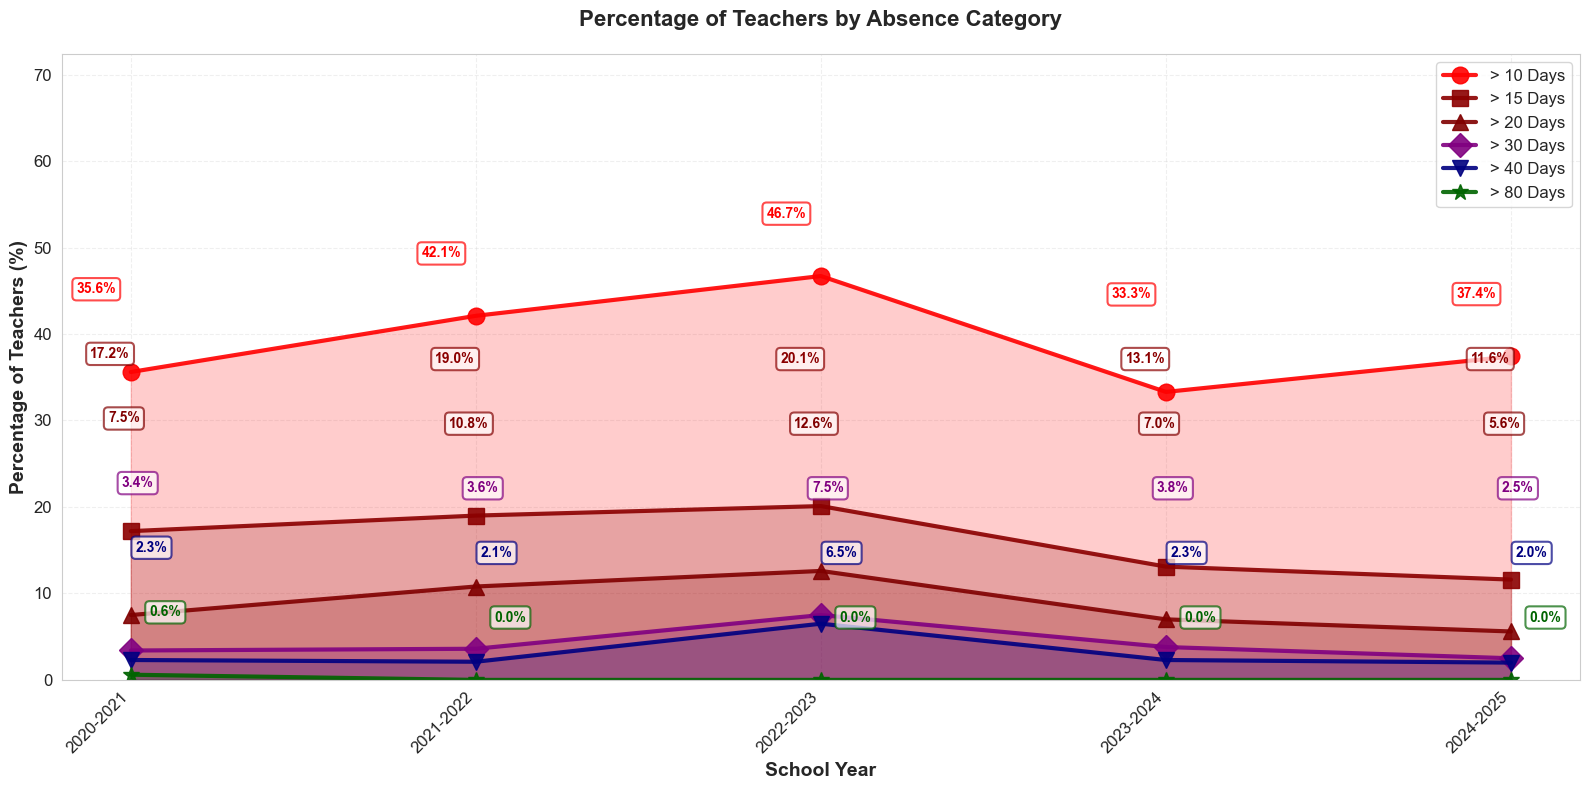

In [ ]:
# Percentage of Teachers by Absence Category
years = sorted(teacher_absence_days['School Year'].unique())

pct_teachers_combined = {}
for threshold in thresholds:
    pcts = []
    for year in years:
        summary = summary_tables[threshold]
        year_data = summary[summary['School Year'] == year]
        if len(year_data) > 0:
            pcts.append(year_data['% of Teachers'].values[0])
        else:
            pcts.append(0)
    pct_teachers_combined[threshold] = pcts

plt.figure(figsize=(16, 8))
plt.plot(years, pct_teachers_combined[10], marker='o', linewidth=3, markersize=12, 
         label='> 10 Days', color='red', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[10], alpha=0.2, color='red')
plt.plot(years, pct_teachers_combined[15], marker='s', linewidth=3, markersize=12, 
         label='> 15 Days', color='darkred', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[15], alpha=0.2, color='darkred')
plt.plot(years, pct_teachers_combined[20], marker='^', linewidth=3, markersize=12, 
         label='> 20 Days', color='maroon', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[20], alpha=0.2, color='maroon')
plt.plot(years, pct_teachers_combined[30], marker='D', linewidth=3, markersize=12, 
         label='> 30 Days', color='purple', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[30], alpha=0.2, color='purple')
plt.plot(years, pct_teachers_combined[40], marker='v', linewidth=3, markersize=12, 
         label='> 40 Days', color='navy', alpha=0.9)
plt.fill_between(years, pct_teachers_combined[40], alpha=0.2, color='navy')

# Set y-axis limit to give more room for labels
max_pct = max(max(pct_teachers_combined[10]), max(pct_teachers_combined[15]), max(pct_teachers_combined[20]),
              max(pct_teachers_combined[30]), max(pct_teachers_combined[40]))
plt.ylim(0, max_pct * 1.55)  # Add 55% more space at top for clear label positioning

# Add percentage labels at each data point - position with much better clearance from markers
for i, year in enumerate(years):
    # Get all values for this year and sort them by value (lowest to highest)
    values_at_year = [(threshold, pct_teachers_combined[threshold][i]) for threshold in [10, 15, 20, 30, 40]]
    values_at_year.sort(key=lambda x: x[1])  # Sort by actual value
    
    # Calculate spacing - use larger values for better readability
    min_spacing = max_pct * 0.16  # Minimum 16% of max percentage between labels (increased from 12%)
    base_clearance = max_pct * 0.12  # 12% of max percentage as minimum clearance above marker (increased from 8%)
    
    # Position labels from bottom to top with generous spacing
    label_positions = {}
    prev_y_pos = None
    
    for rank, (threshold, value) in enumerate(values_at_year):
        # Calculate desired position well above the marker
        desired_pos = value + base_clearance + 0.8
        
        # If this isn't the first label, ensure it's well spaced above the previous one
        if prev_y_pos is not None:
            # Make sure there's enough spacing between labels
            if desired_pos < prev_y_pos + min_spacing:
                y_pos = prev_y_pos + min_spacing
            else:
                y_pos = desired_pos
        else:
            # First (lowest) label - ensure good clearance from marker
            y_pos = desired_pos
        
        label_positions[threshold] = y_pos
        prev_y_pos = y_pos
    
    # Plot labels with better positioning - slightly offset horizontally to avoid marker overlap
    color_map = {10: 'red', 15: 'darkred', 20: 'maroon', 30: 'purple', 40: 'navy'}
    # Horizontal offset pattern to spread labels left/right slightly
    h_offsets = {10: -0.08, 15: -0.04, 20: 0.0, 30: 0.04, 40: 0.08}
    
    for threshold in [10, 15, 20, 30, 40]:
        value = pct_teachers_combined[threshold][i]
        y_pos = label_positions[threshold]
        color = color_map[threshold]
        # Add horizontal offset to avoid direct overlap with markers
        x_pos = i + h_offsets[threshold]
        plt.text(x_pos, y_pos, f'{value:.1f}%', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color=color,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.7, linewidth=1.5))

plt.title('Percentage of Teachers by Absence Category', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Teachers (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


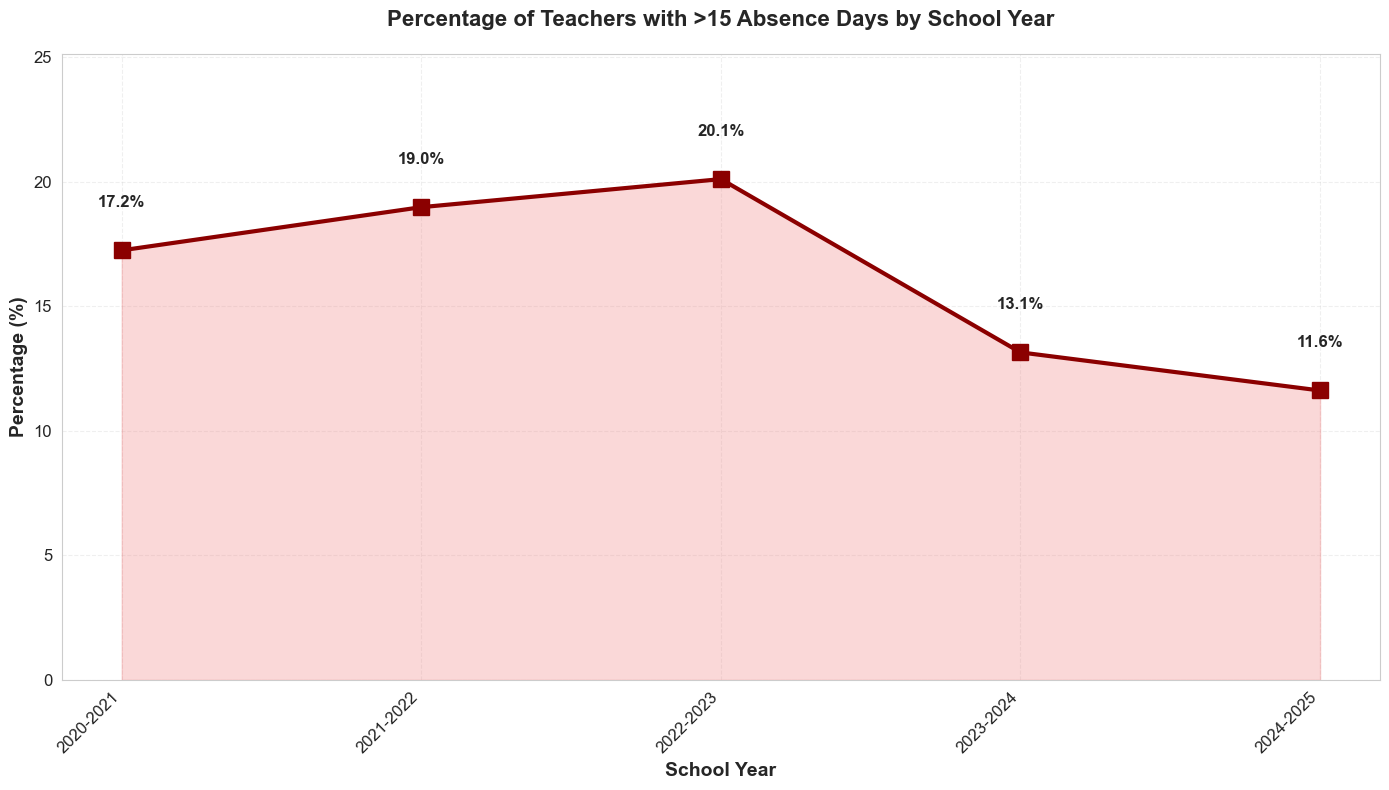

In [ ]:
# Percentage of Teachers with >15 Absence Days by School Year
threshold = 15
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='s', linewidth=3, markersize=12, color='darkred')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightcoral')

# Set y-axis limit to give more room for labels
max_pct = max(pct_teachers) if pct_teachers else 0
plt.ylim(0, max_pct * 1.25)  # Add 25% more space at top

plt.title(f'Percentage of Teachers with >15 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Position labels with better offset (proportional to max value)
offset = max(max_pct * 0.08, 1.5)  # Use 8% of max or at least 1.5
for i, v in enumerate(pct_teachers):
    plt.text(i, v + offset, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


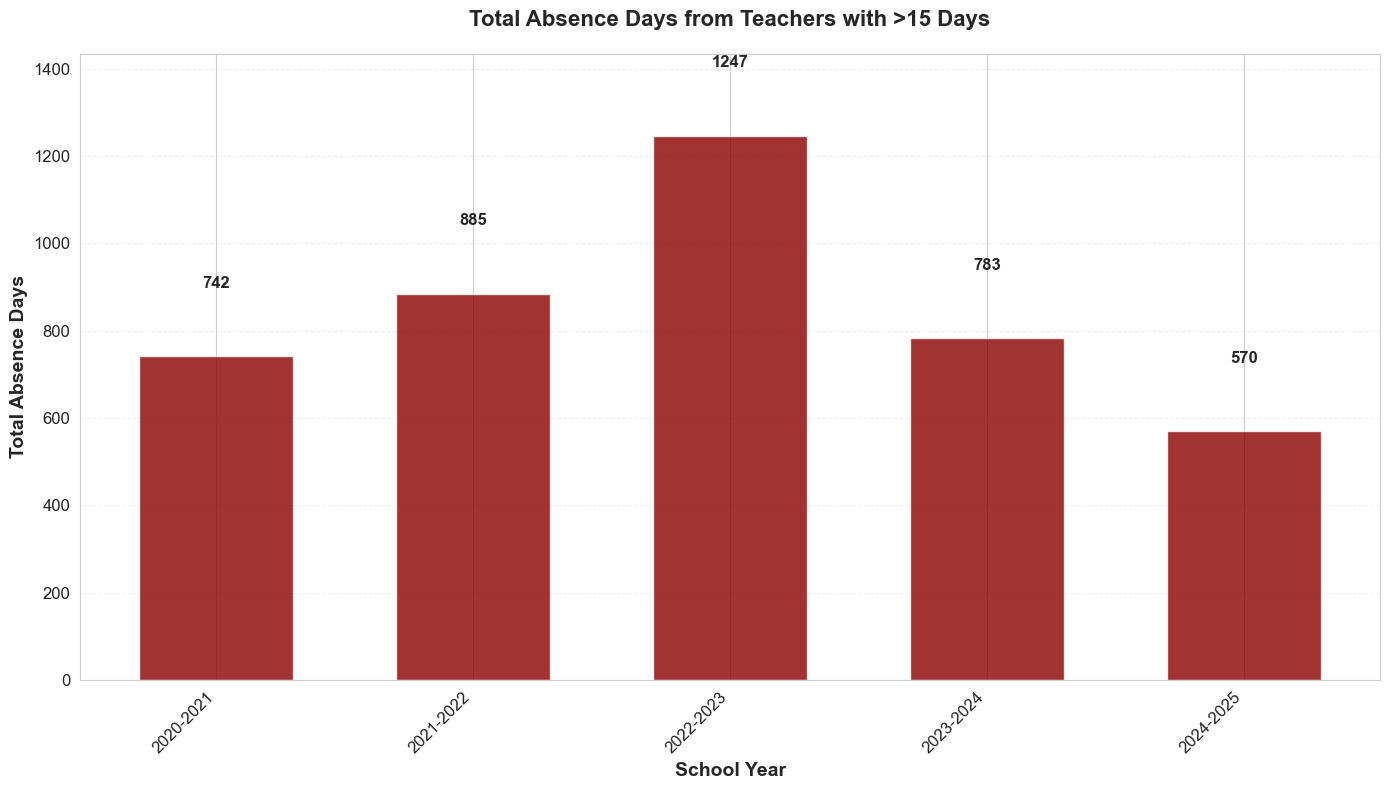

In [ ]:
# Total Absence Days from Teachers with >15 Days
threshold = 15
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='darkred', width=0.6, alpha=0.8)

# Set y-axis limit to give more room for labels
max_value = max(total_days) if total_days else 0
plt.ylim(0, max_value * 1.15)  # Add 15% more space at top

plt.title(f'Total Absence Days from Teachers with >15 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Position labels with better offset (proportional to max value)
offset = max(max_value * 0.08, 150)  # Use 8% of max or at least 150
for i, v in enumerate(total_days):
    plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


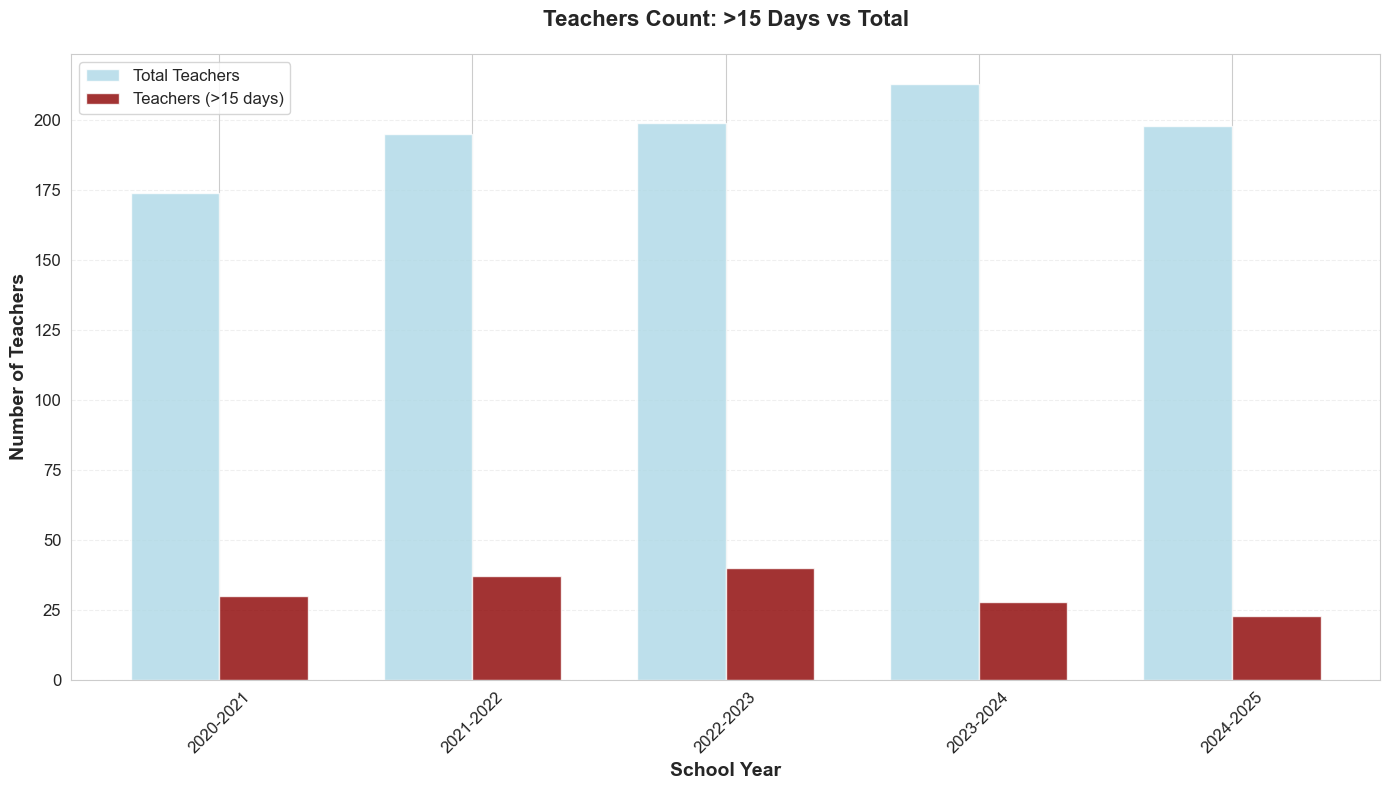

In [ ]:
# Teachers Count: >15 Days vs Total
threshold = 15
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>15 days)', color='darkred', alpha=0.8)
plt.title(f'Teachers Count: >15 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


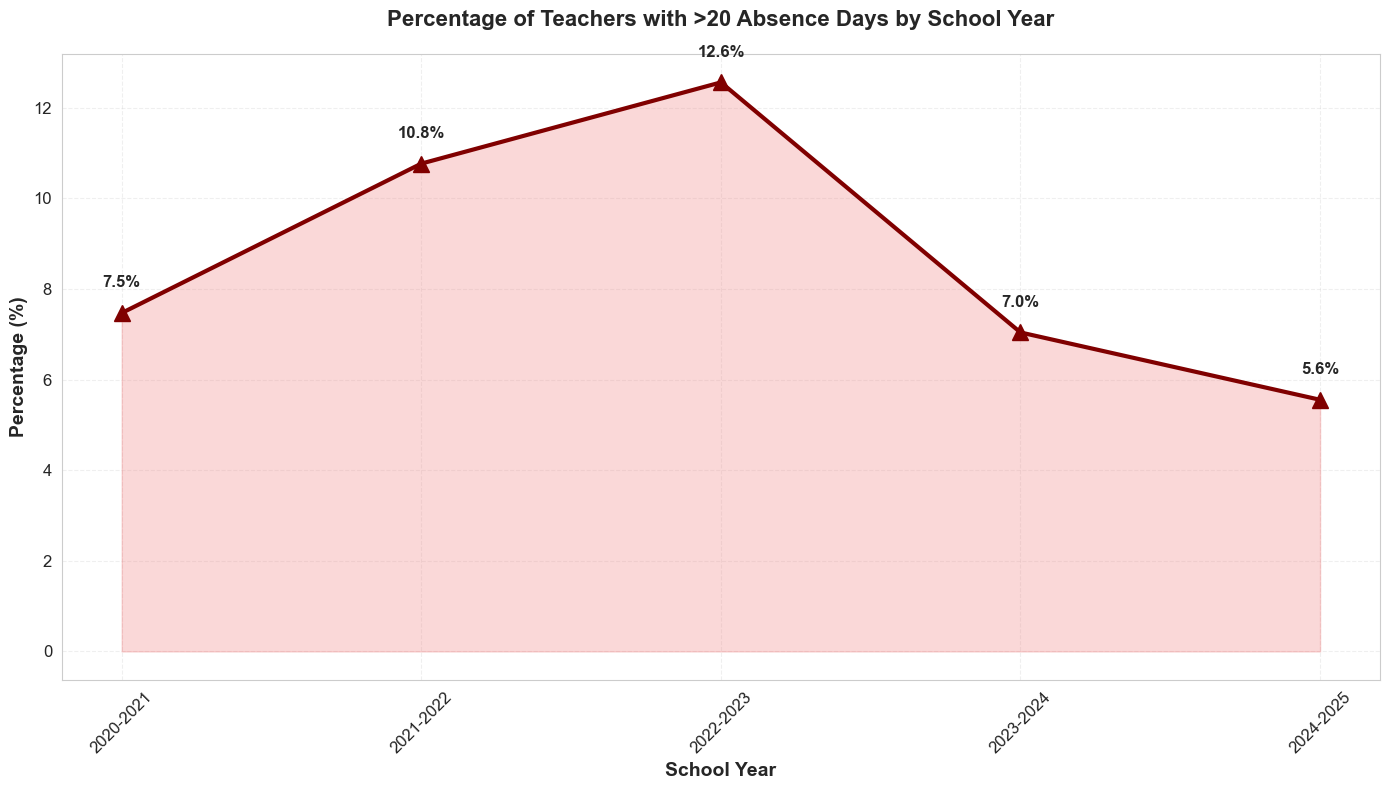

In [ ]:
# Percentage of Teachers with >20 Absence Days by School Year
threshold = 20
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='^', linewidth=3, markersize=12, color='maroon')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightcoral')
plt.title(f'Percentage of Teachers with >20 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
for i, v in enumerate(pct_teachers):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


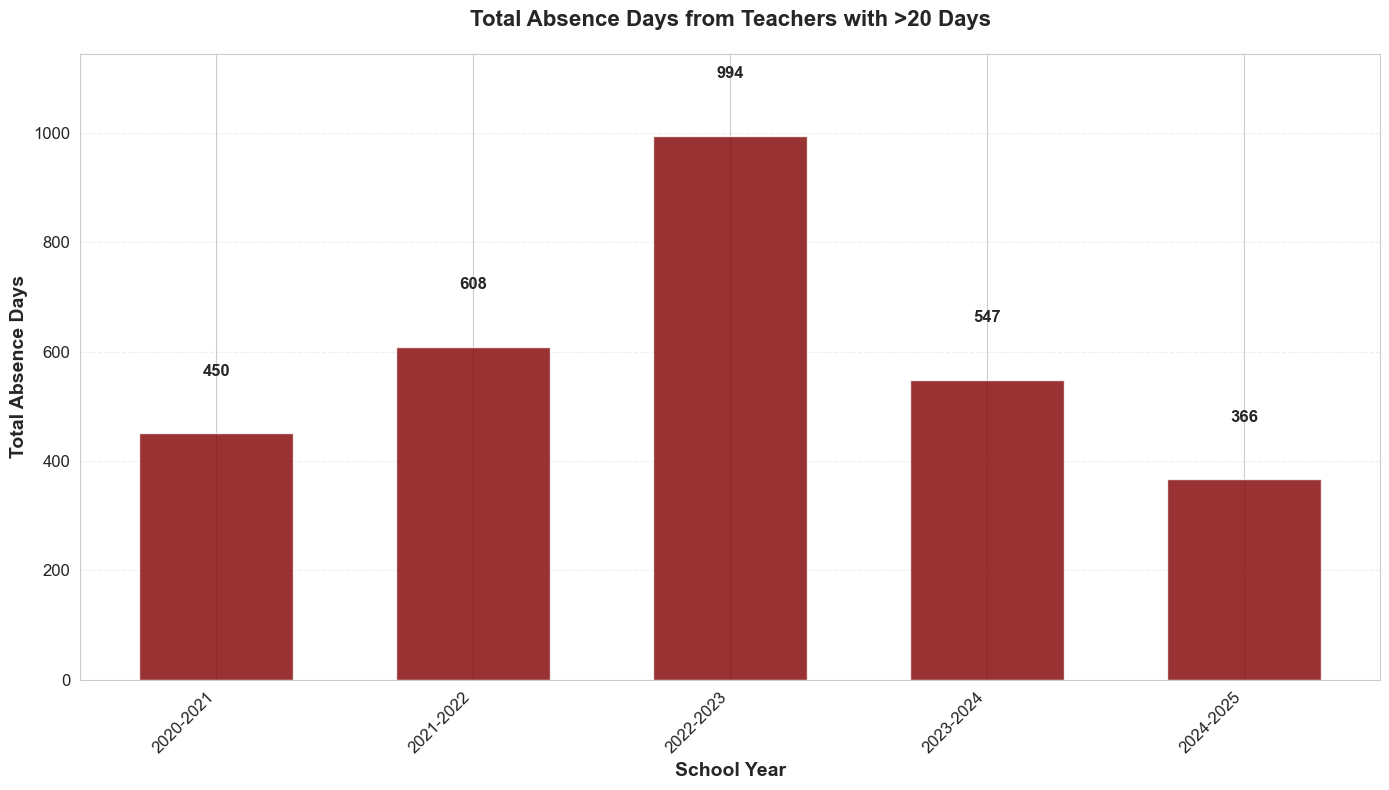

In [ ]:
# Total Absence Days from Teachers with >20 Days
threshold = 20
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='maroon', width=0.6, alpha=0.8)

# Set y-axis limit to give more room for labels
max_value = max(total_days) if total_days else 0
plt.ylim(0, max_value * 1.15)  # Add 15% more space at top

plt.title(f'Total Absence Days from Teachers with >20 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Position labels with better offset (proportional to max value)
offset = max(max_value * 0.08, 100)  # Use 8% of max or at least 100
for i, v in enumerate(total_days):
    plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


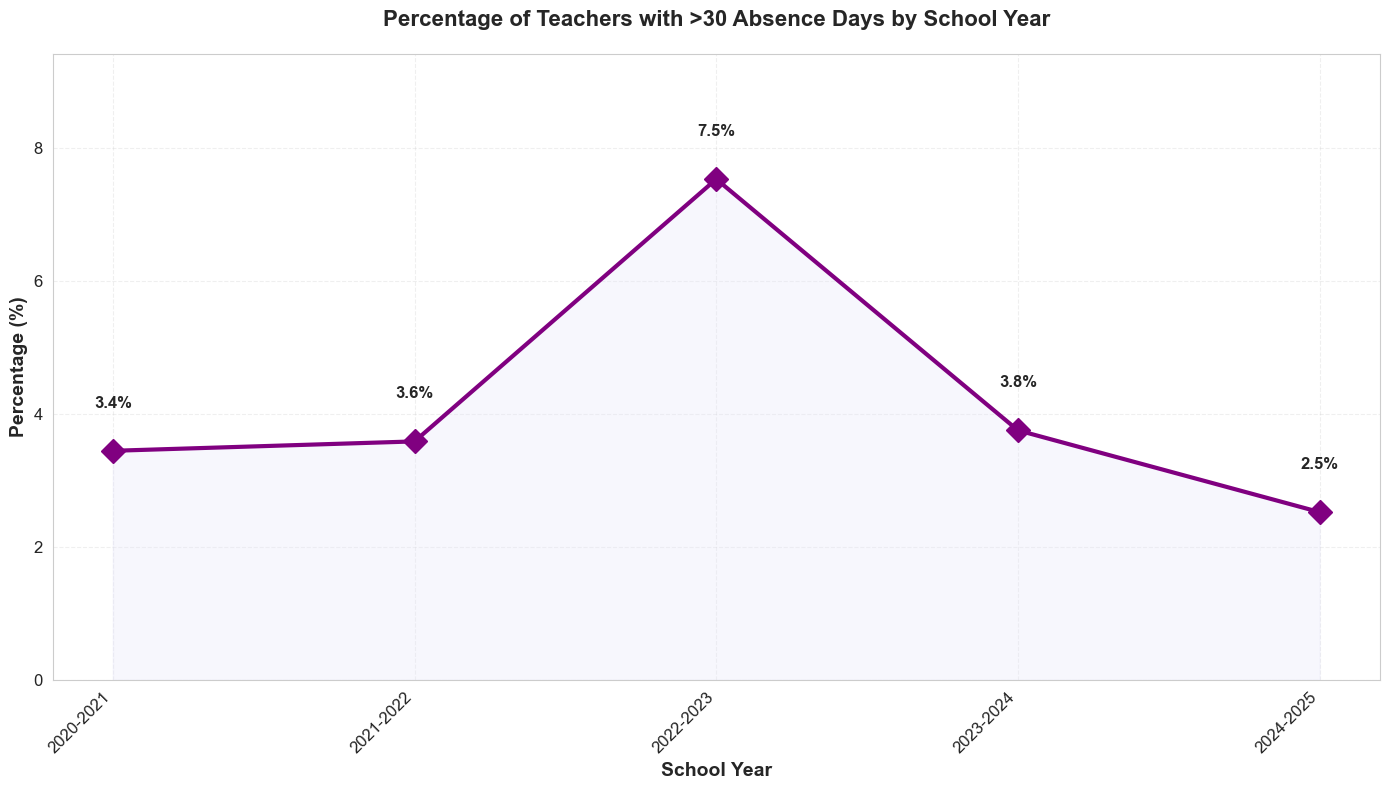

In [ ]:
# Percentage of Teachers with >30 Absence Days by School Year
threshold = 30
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='D', linewidth=3, markersize=12, color='purple')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lavender')

# Set y-axis limit to give more room for labels
max_pct = max(pct_teachers) if pct_teachers else 0
plt.ylim(0, max_pct * 1.25)  # Add 25% more space at top

plt.title(f'Percentage of Teachers with >30 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Position labels with better offset
offset = max(max_pct * 0.08, 0.5)  # Use 8% of max or at least 0.5
for i, v in enumerate(pct_teachers):
    plt.text(i, v + offset, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


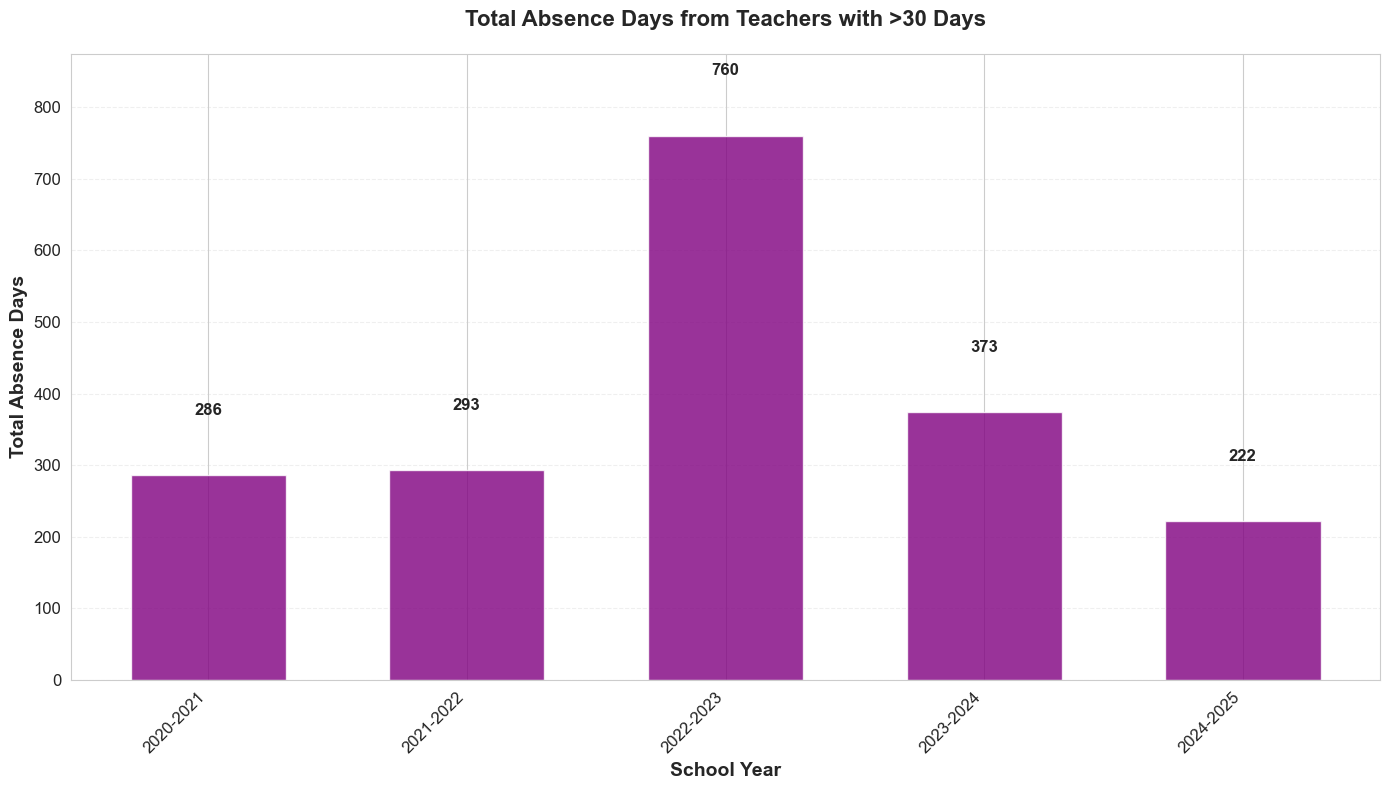

In [ ]:
# Total Absence Days from Teachers with >30 Days
threshold = 30
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='purple', width=0.6, alpha=0.8)

# Set y-axis limit to give more room for labels
max_value = max(total_days) if total_days else 0
plt.ylim(0, max_value * 1.15)  # Add 15% more space at top

plt.title(f'Total Absence Days from Teachers with >30 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Position labels with better offset
offset = max(max_value * 0.08, 80)  # Use 8% of max or at least 80
for i, v in enumerate(total_days):
    plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


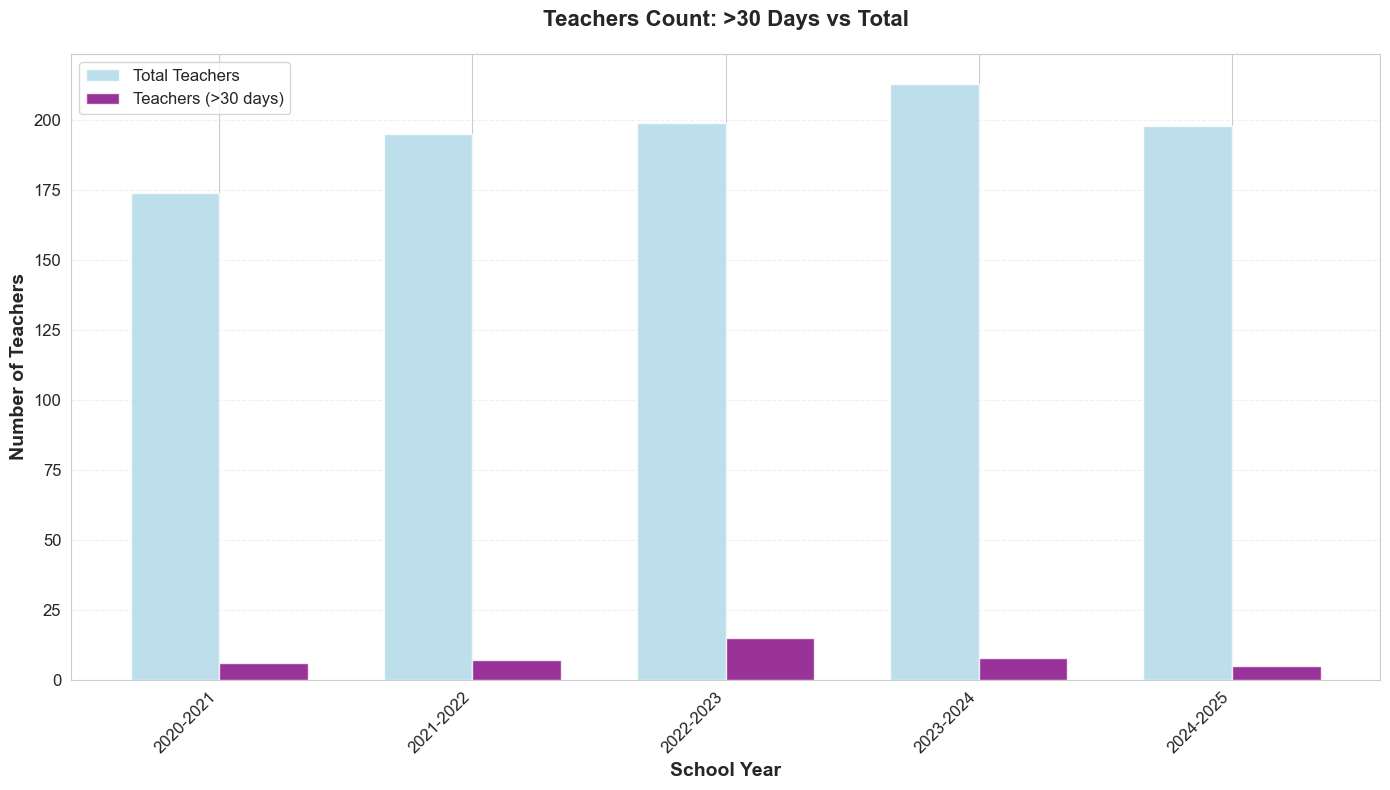

In [ ]:
# Teachers Count: >30 Days vs Total
threshold = 30
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>30 days)', color='purple', alpha=0.8)
plt.title(f'Teachers Count: >30 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


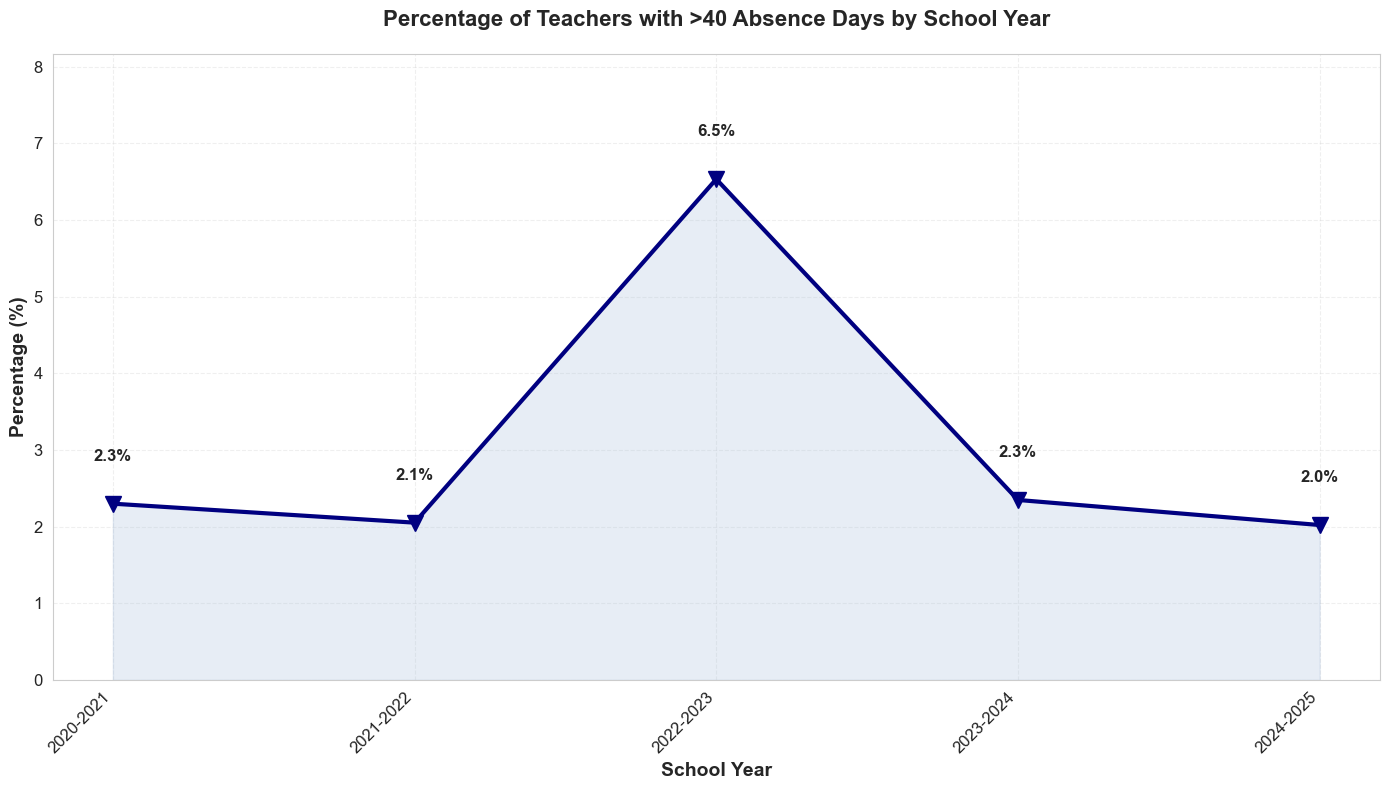

In [ ]:
# Percentage of Teachers with >40 Absence Days by School Year
threshold = 40
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='v', linewidth=3, markersize=12, color='navy')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightsteelblue')

# Set y-axis limit to give more room for labels
max_pct = max(pct_teachers) if pct_teachers else 0
plt.ylim(0, max_pct * 1.25)  # Add 25% more space at top

plt.title(f'Percentage of Teachers with >40 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Position labels with better offset
offset = max(max_pct * 0.08, 0.5)  # Use 8% of max or at least 0.5
for i, v in enumerate(pct_teachers):
    plt.text(i, v + offset, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


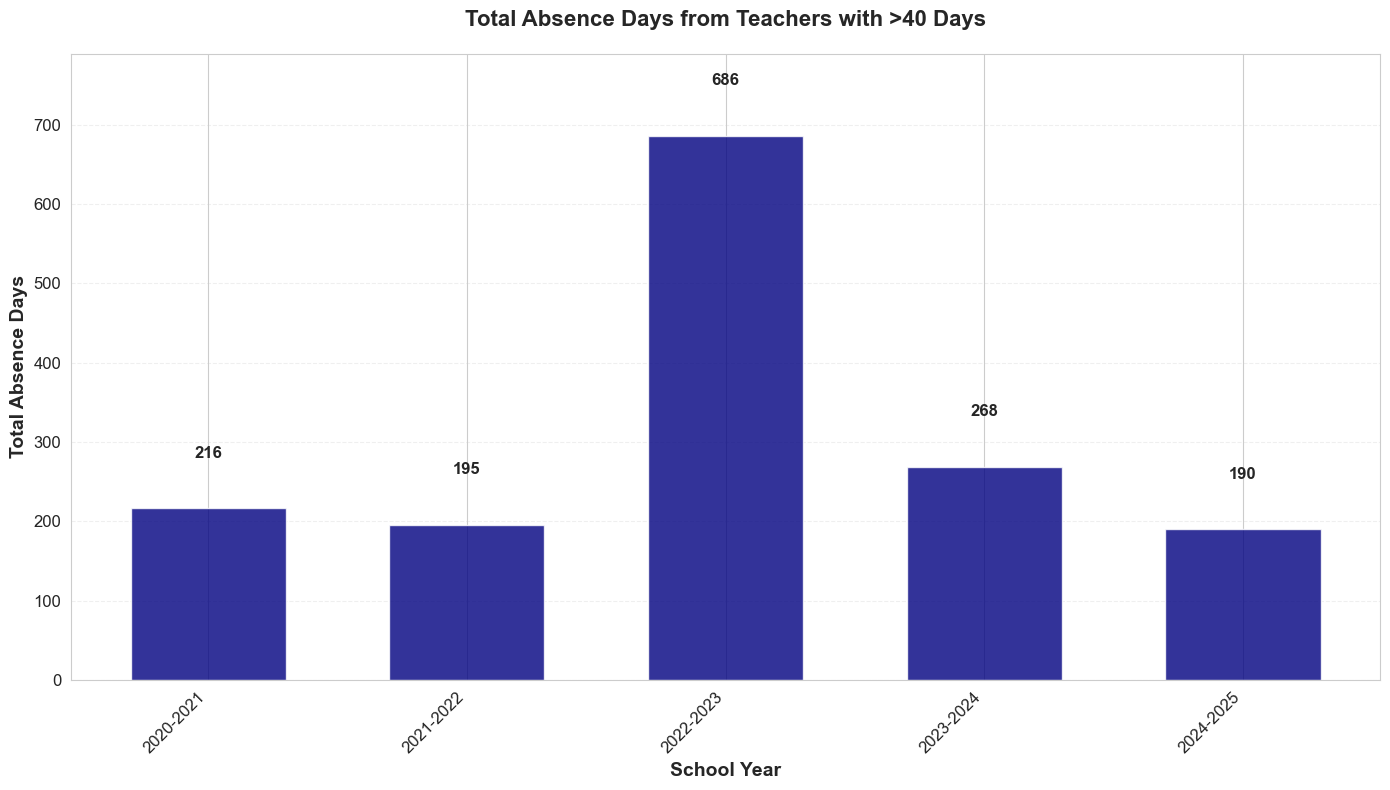

In [ ]:
# Total Absence Days from Teachers with >40 Days
threshold = 40
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='navy', width=0.6, alpha=0.8)

# Set y-axis limit to give more room for labels
max_value = max(total_days) if total_days else 0
plt.ylim(0, max_value * 1.15)  # Add 15% more space at top

plt.title(f'Total Absence Days from Teachers with >40 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Position labels with better offset
offset = max(max_value * 0.08, 60)  # Use 8% of max or at least 60
for i, v in enumerate(total_days):
    plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


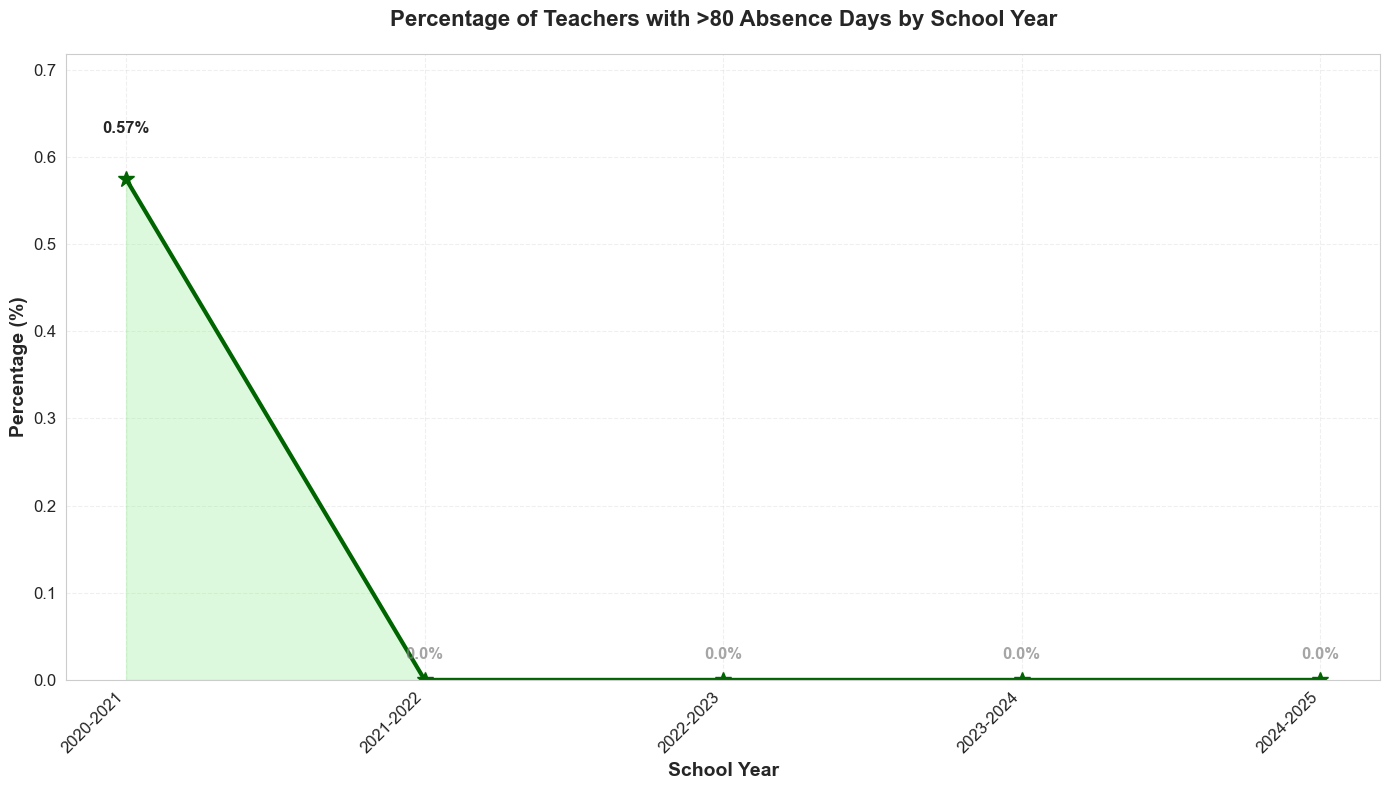

In [ ]:
# Percentage of Teachers with >80 Absence Days by School Year
threshold = 80
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
pct_teachers = [data['pct_teachers'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.plot(years, pct_teachers, marker='*', linewidth=3, markersize=12, color='darkgreen')
plt.fill_between(years, pct_teachers, alpha=0.3, color='lightgreen')

# Set y-axis limit to give more room for labels
max_pct = max(pct_teachers) if pct_teachers else 0
if max_pct == 0:
    plt.ylim(0, 1)  # Set minimum range when all values are 0
else:
    plt.ylim(0, max(max_pct * 1.25, 0.5))  # Add 25% more space at top, minimum 0.5%

plt.title(f'Percentage of Teachers with >80 Absence Days by School Year', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')

# Position labels with better offset
for i, v in enumerate(pct_teachers):
    if v > 0:
        offset = max(max_pct * 0.08, 0.05)  # Use 8% of max or at least 0.05
        plt.text(i, v + offset, f'{v:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    else:
        # Show 0% label for zero values
        plt.text(i, 0.02, '0.0%', ha='center', va='bottom', fontsize=12, fontweight='bold', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

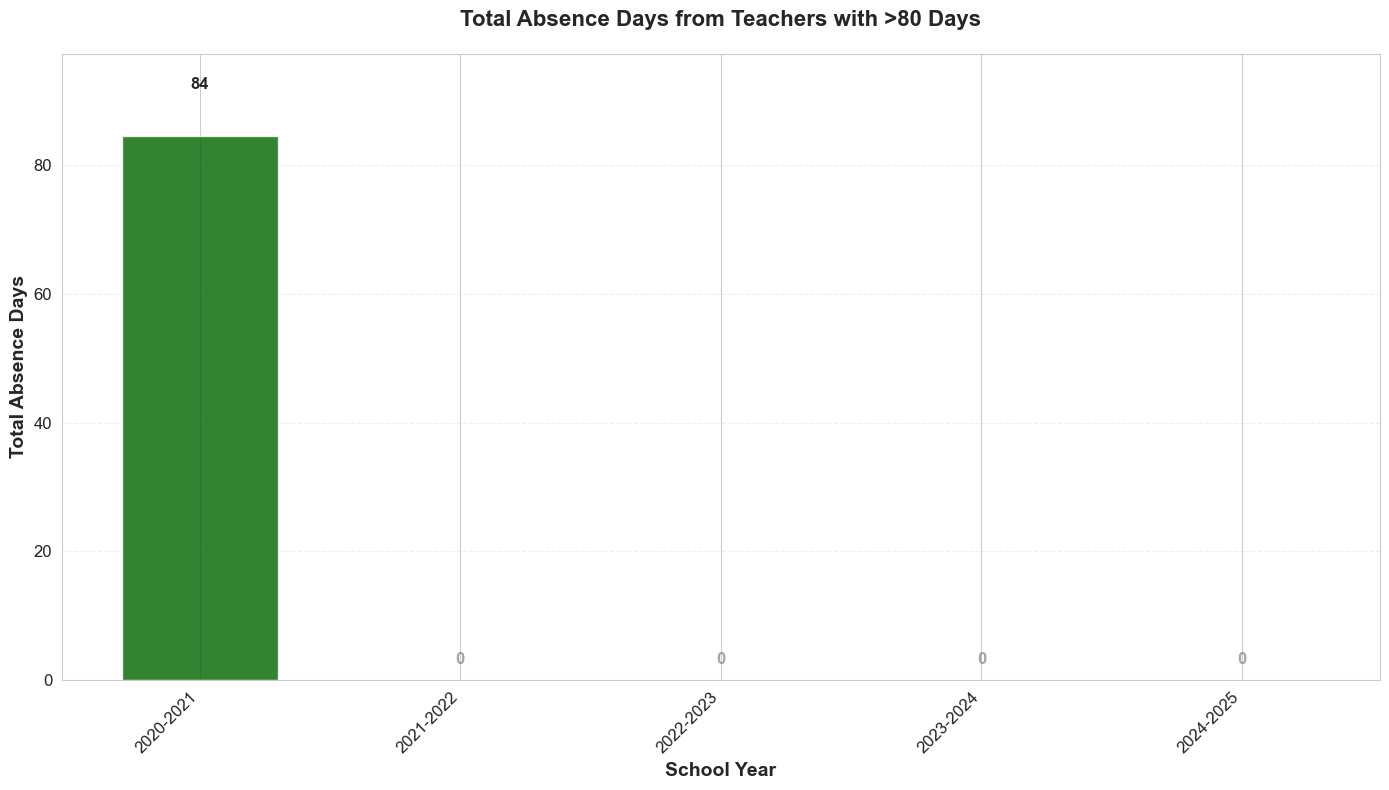

In [ ]:
# Total Absence Days from Teachers with >80 Days
threshold = 80
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_days = [data['total_days_above'].get(year, 0) for year in years]

plt.figure(figsize=(14, 8))
plt.bar(years, total_days, color='darkgreen', width=0.6, alpha=0.8)

# Set y-axis limit to give more room for labels
max_value = max(total_days) if total_days else 0
if max_value == 0:
    plt.ylim(0, 50)  # Set minimum range when all values are 0
else:
    plt.ylim(0, max_value * 1.15)  # Add 15% more space at top

plt.title(f'Total Absence Days from Teachers with >80 Days', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Total Absence Days', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, ha='right')  # Align rotated labels to the right
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Position labels with better offset
for i, v in enumerate(total_days):
    if v > 0:
        offset = max(max_value * 0.08, 5)  # Use 8% of max or at least 5
        plt.text(i, v + offset, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    else:
        # Show 0 label for zero values
        plt.text(i, 2, '0', ha='center', va='bottom', fontsize=12, fontweight='bold', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

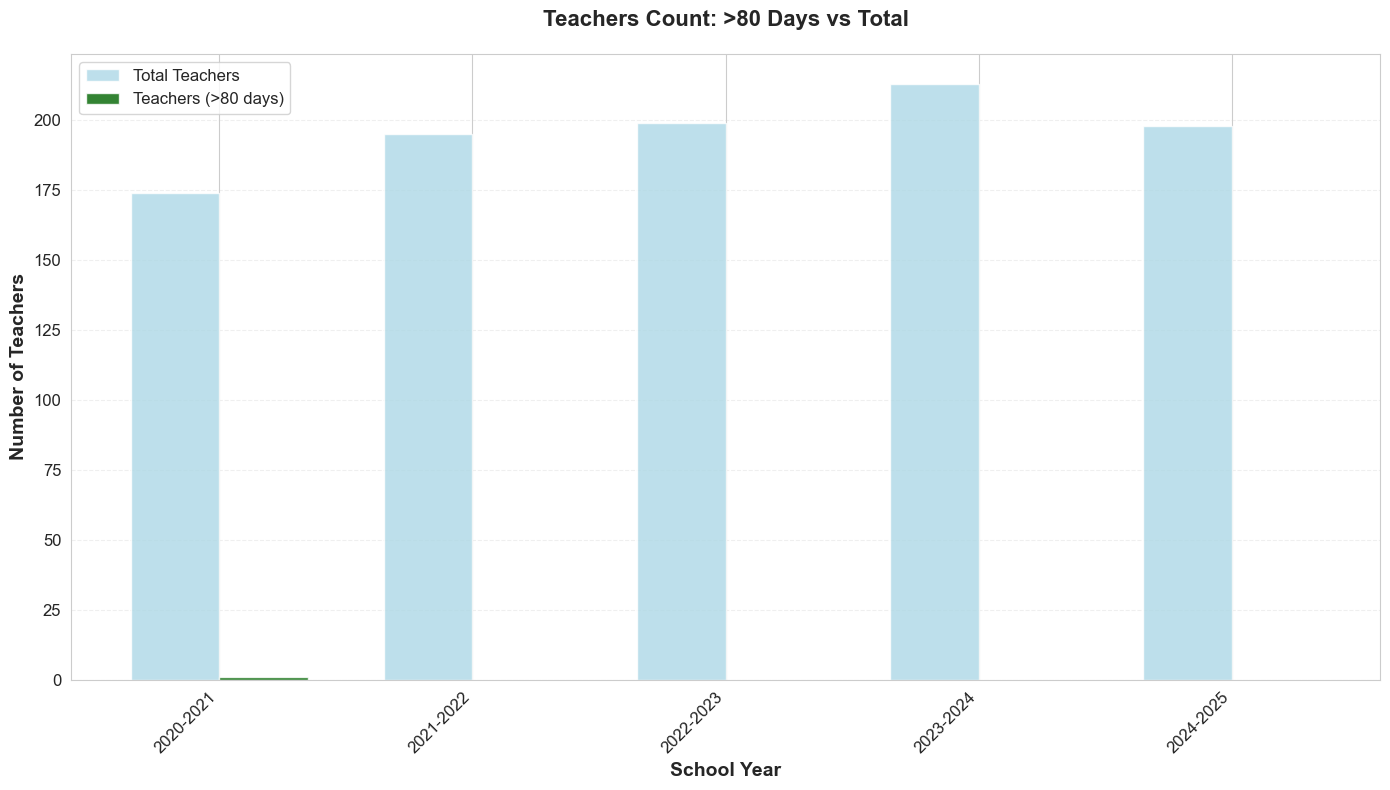

In [ ]:
# Teachers Count: >80 Days vs Total
threshold = 80
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>80 days)', color='darkgreen', alpha=0.8)
plt.title(f'Teachers Count: >80 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

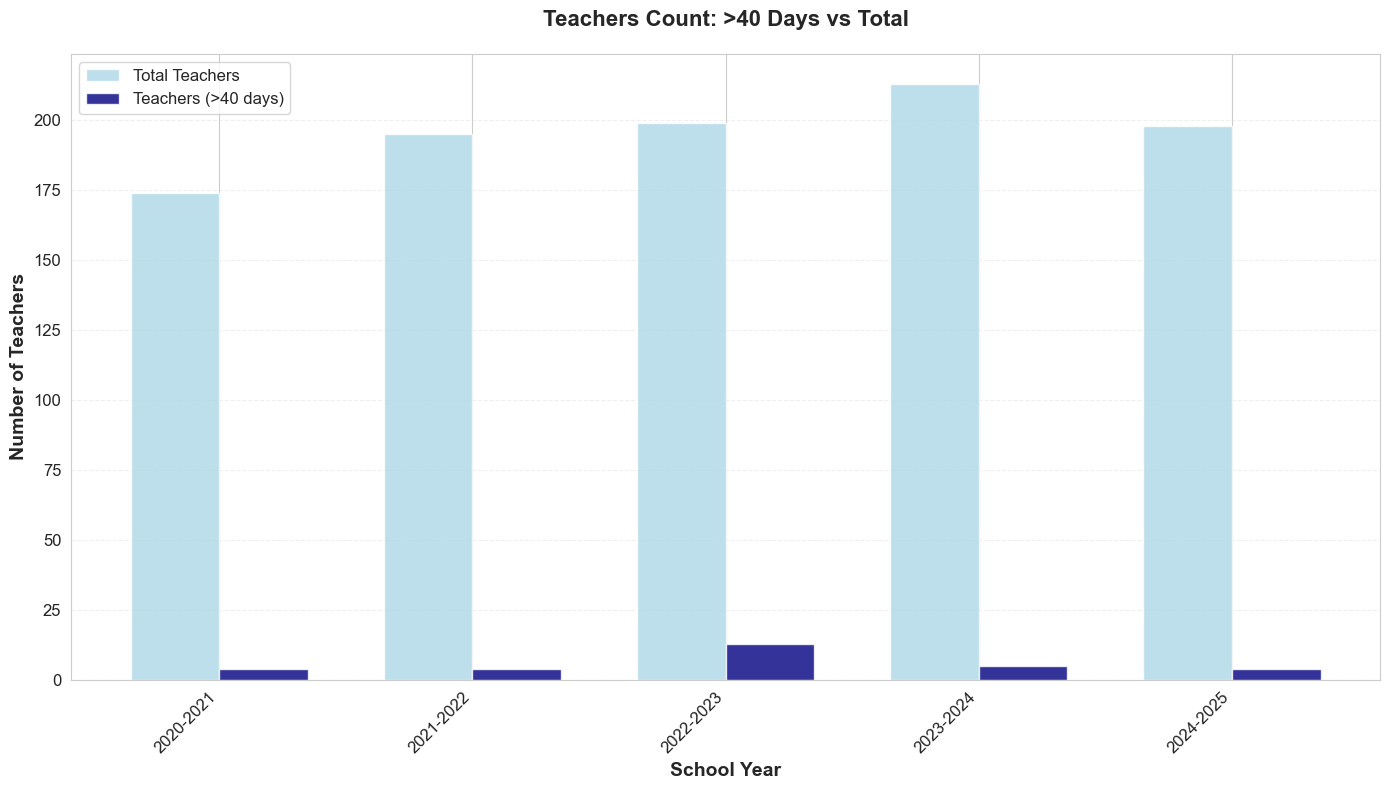

In [ ]:
# Teachers Count: >40 Days vs Total
threshold = 40
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>40 days)', color='navy', alpha=0.8)
plt.title(f'Teachers Count: >40 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


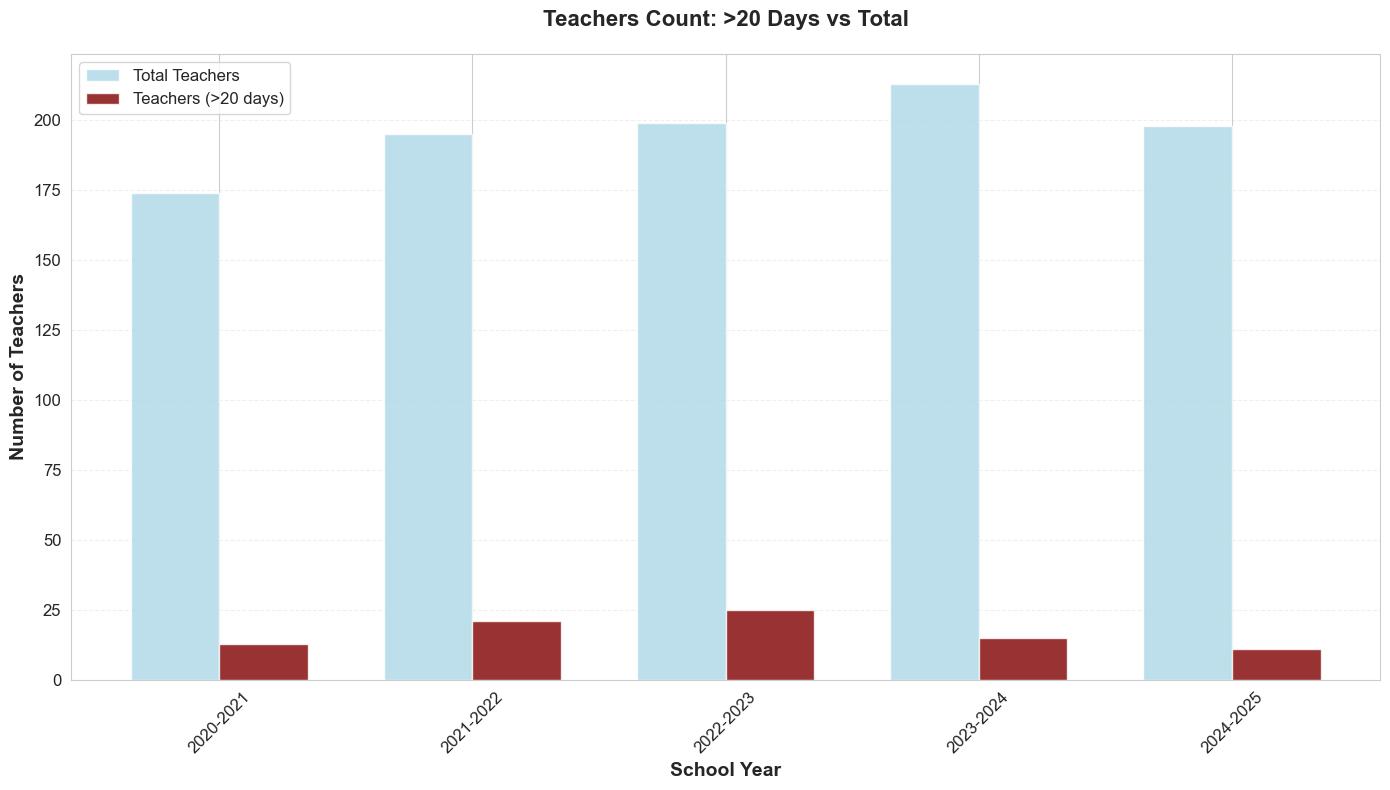

In [ ]:
# Teachers Count: >20 Days vs Total
threshold = 20
data = results[threshold]

years = sorted(teacher_absence_days['School Year'].unique())
total_teachers = [data['total_teachers'].get(year, 0) for year in years]
teachers_above = [data['teachers_above'].get(year, 0) for year in years]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, total_teachers, width, label='Total Teachers', color='lightblue', alpha=0.8)
plt.bar(x + width/2, teachers_above, width, label=f'Teachers (>20 days)', color='maroon', alpha=0.8)
plt.title(f'Teachers Count: >20 Days vs Total', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('School Year', fontsize=14, fontweight='bold')
plt.ylabel('Number of Teachers', fontsize=14, fontweight='bold')
plt.xticks(x, years, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()
